# * Business Growth Overview

## Import Data Source
Monitoring Job : 9.00 / 14.00 / 18.00 / 22.00

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from functools import reduce
import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

##### *** "TDG Revenue (Performance View)" or "TDG Revenue (Conso View)" ? : 
- AGG_TYPE = N

In [2]:
data_src = "Raw-Agg Perf Nationwide_Wk 2023022.csv"
df = pd.read_csv(data_src, low_memory=False)
# cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
df = df[cols]

''' Fix Metric CD list '''
prepaid_rev_cd_list = ['B1R000100', 'DB1R000100', 'TB1R000100']
postpaid_rev_cd_list = ['B2R000100', 'DB2R000100', 'TB2R000100']
# tol_tvs_tdg_rev_cd_list = ['TB3R000100', 'TB4R000100', 'TNSC00142'] # include "TDG Revenue (Performance View)"
tol_tvs_tdg_rev_cd_list = ['TB3R000100', 'TB4R000100', 'TNSC00143'] # include "TDG Revenue (Conso View)"
bg_rev_all_cd_list = prepaid_rev_cd_list + postpaid_rev_cd_list + tol_tvs_tdg_rev_cd_list
# bg_rev_sum_cd_list = ['DB1R000100', 'TB1R000100', 'DB2R000100', 'TB2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142'] # Exclude : Total of PRE & POST
# bg_rev_sum_cd_list = ['B1R000100', 'B2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142'] # include "TDG Revenue (Performance View)"

''' Fix Agg Column Name(Total Revenue) '''
# bg_act_col_list = ['ACT_POST', 'ACT_PRE', 'ACT_TOL', 'ACT_TVS']
# bg_tgt_col_list = ['TGT_POST', 'TGT_PRE', 'TGT_TOL', 'TGT_TVS']
# bg_last_act_col_list = ['LAST_ACT_POST', 'LAST_ACT_PRE', 'LAST_ACT_TOL', 'LAST_ACT_TVS']
bg_act_col_list = ['ACT_POST_DTAC', 'ACT_POST_TMH', 'ACT_PRE_DTAC', 'ACT_PRE_TMH', 'ACT_TOL', 'ACT_TVS']
bg_tgt_col_list = ['TGT_POST_DTAC', 'TGT_POST_TMH', 'TGT_PRE_DTAC', 'TGT_PRE_TMH', 'TGT_TOL', 'TGT_TVS']
bg_last_act_col_list = ['LAST_ACT_POST_DTAC', 'LAST_ACT_POST_TMH', 'LAST_ACT_PRE_DTAC', 'LAST_ACT_PRE_TMH', 'LAST_ACT_TOL', 'LAST_ACT_TVS']

In [3]:
df.shape
# df['METRIC_NAME'].unique()

(52400, 13)

In [4]:
# ''' Find Metric '''

# # df_metric = df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()
# df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
# df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
# df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]#.reset_index()
# df_metric = pd.concat([df_agg_s, df_agg_n])
# df_metric

# # df_tmp = df_metric[df_metric['METRIC_GRP']=="Revenue"]
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")]#.reset_index()
# # # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()
# # df_tmp = df_tmp[df_tmp['PRODUCT_GRP']=="TVS"]

# # # df_tmp.to_excel('Prepaid_Metric.xlsx')
# # df_tmp

## Data Preporation

In [5]:
''' Rawdata '''

''' Function : Unit Million Baht '''
def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

''' Filters '''
# df = df[df['TM_KEY_MTH'] <= 202305] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
df = df[df['TM_KEY_DAY'] <= 20230606] # DAY filter
df = df[df['METRIC_CD'].isin(bg_rev_all_cd_list)]#.reset_index()

''' Modify '''
df.loc[:, 'ACTUAL_SNAP'] = unit_mb(df['ACTUAL_SNAP'])
df.loc[:, 'ACTUAL_AGG'] = unit_mb(df['ACTUAL_AGG'])
df.loc[:, 'TARGET_SNAP'] = unit_mb(df['TARGET_SNAP'])
df.loc[:, 'TARGET_AGG'] = unit_mb(df['TARGET_AGG'])

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)
df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,METRIC_CD,METRIC_NAME,AGG_TYPE,ACTUAL_SNAP,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
48195,20230604,2023022,202306,20232,2023,TB4R000100,TVS Revenue,S,NaN,41.426035,NaN,47.555946,2023-06-09 17:51:25,June,22,4
48196,20230605,2023023,202306,20232,2023,TB4R000100,TVS Revenue,S,NaN,41.426035,NaN,47.555946,2023-06-09 17:51:25,June,23,5
48197,20230606,2023023,202306,20232,2023,TB4R000100,TVS Revenue,S,11.795993,53.222028,12.000523,59.556469,2023-06-09 17:51:25,June,23,6


In [6]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACTUAL_SNAP')

In [7]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
# last_wk_tmp = df[['TM_KEY_YR', 'TM_KEY_WK']].drop_duplicates()['TM_KEY_WK'].shift().max()
curr_day = df['TM_KEY_DAY'].max()
last_ppn_tm = df['PPN_TM'].max()

### DAY : Aggregation (base level)

In [8]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 'AGG_TYPE', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG']
df_rev_day = df[cols_agg].reset_index()
# df_rev_day = df_rev_day[df_rev_day['TM_KEY_MTH']>=202305]
# df_rev_day = df_rev_day[df_rev_day['TM_KEY_WK']>=2023021]
# df_rev_day = df_rev_day[df_rev_day['TM_KEY_DAY']>=20230529]
# df_rev_day = df_rev_day[df_rev_day['AGG_TYPE']=='N']
# df_rev_day = df_rev_day[df_rev_day['METRIC_NAME']=="TDG Revenue (Conso View)"]

''' Aggregation '''
df_rev_day['ACTUAL'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['ACTUAL_AGG'], df_rev_day['ACTUAL_SNAP'])
df_rev_day['TARGET'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['TARGET_AGG'], df_rev_day['TARGET_SNAP'])
df_rev_day['%ACHV'] = df_rev_day['ACTUAL'] / df_rev_day['TARGET']
df_rev_day['GAP'] = df_rev_day['ACTUAL'] - df_rev_day['TARGET']
df_rev_day['LAST_ACT'] = df_rev_day.groupby('METRIC_CD')['ACTUAL'].shift()
df_rev_day['DIFF'] = df_rev_day['ACTUAL'] - df_rev_day['LAST_ACT']
df_rev_day['%DOD'] = (df_rev_day['ACTUAL'] / df_rev_day['LAST_ACT']) - 1

# # df_rev_day.to_excel('df_rev_mth.xlsx')
df_rev_day.tail(10)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG,ACTUAL,TARGET,%ACHV,GAP,LAST_ACT,DIFF,%DOD
872,48188,TB4R000100,TVS Revenue,20230528,2023021,202305,20232,2023,May,28,...,249.528637,16.599735,265.776482,28.206667,16.599735,1.699224,11.606932,NaN,NaN,NaN
873,48189,TB4R000100,TVS Revenue,20230529,2023022,202305,20232,2023,May,29,...,249.528637,NaN,265.776482,NaN,NaN,NaN,NaN,28.206667,NaN,NaN
874,48190,TB4R000100,TVS Revenue,20230530,2023022,202305,20232,2023,May,30,...,249.528637,NaN,265.776482,NaN,NaN,NaN,NaN,NaN,NaN,NaN
875,48191,TB4R000100,TVS Revenue,20230531,2023022,202305,20232,2023,May,31,...,376.219863,147.839864,413.616346,126.691226,147.839864,0.856949,-21.148638,NaN,NaN,NaN
876,48192,TB4R000100,TVS Revenue,20230601,2023022,202306,20232,2023,June,1,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,126.691226,NaN,NaN
877,48193,TB4R000100,TVS Revenue,20230602,2023022,202306,20232,2023,June,2,...,41.426035,47.555946,47.555946,41.426035,47.555946,0.871101,-6.129911,NaN,NaN,NaN
878,48194,TB4R000100,TVS Revenue,20230603,2023022,202306,20232,2023,June,3,...,41.426035,NaN,47.555946,NaN,NaN,NaN,NaN,41.426035,NaN,NaN
879,48195,TB4R000100,TVS Revenue,20230604,2023022,202306,20232,2023,June,4,...,41.426035,NaN,47.555946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
880,48196,TB4R000100,TVS Revenue,20230605,2023023,202306,20232,2023,June,5,...,41.426035,NaN,47.555946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
881,48197,TB4R000100,TVS Revenue,20230606,2023023,202306,20232,2023,June,6,...,53.222028,12.000523,59.556469,11.795993,12.000523,0.982957,-0.204530,NaN,NaN,NaN


In [9]:
''' Pivot by KPIS '''

''' Pivot Actual '''
pv_rev_day_act = df_rev_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', values='ACTUAL_SNAP').reset_index()
pv_rev_day_act.rename(columns=({'Postpaid Revenue': 'ACT_POST', 'Postpaid Revenue : DTAC': 'ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'ACT_POST_TMH', 
                                'Prepaid Revenue': 'ACT_PRE', 'Prepaid Revenue : DTAC': 'ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'ACT_PRE_TMH', 
                                'TDG Revenue (Conso View)': 'ACT_TDG', 'TOL Revenue': 'ACT_TOL', 'TVS Revenue': 'ACT_TVS'}), inplace=True)
''' Pivot Target '''
pv_rev_day_tgt = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='TARGET_SNAP')
pv_rev_day_tgt.rename(columns=({'Postpaid Revenue': 'TGT_POST', 'Postpaid Revenue : DTAC': 'TGT_POST_DTAC', 'Postpaid Revenue : TMH': 'TGT_POST_TMH', 
                                'Prepaid Revenue': 'TGT_PRE', 'Prepaid Revenue : DTAC': 'TGT_PRE_DTAC', 'Prepaid Revenue : TMH': 'TGT_PRE_TMH', 
                                'TDG Revenue (Conso View)': 'TGT_TDG', 'TOL Revenue': 'TGT_TOL', 'TVS Revenue': 'TGT_TVS'}), inplace=True)
''' Pivot %Achievement '''
pv_rev_day_achv = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='%ACHV')
pv_rev_day_achv.rename(columns=({'Postpaid Revenue': '%ACHV_POST', 'Postpaid Revenue : DTAC': '%ACHV_POST_DTAC', 'Postpaid Revenue : TMH': '%ACHV_POST_TMH', 
                                 'Prepaid Revenue': '%ACHV_PRE', 'Prepaid Revenue : DTAC': '%ACHV_PRE_DTAC', 'Prepaid Revenue : TMH': '%ACHV_PRE_TMH', 
                                 'TDG Revenue (Conso View)': '%ACHV_TDG', 'TOL Revenue': '%ACHV_TOL', 'TVS Revenue': '%ACHV_TVS'}), inplace=True)
''' Pivot Gap '''
pv_rev_day_gap = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='GAP')
pv_rev_day_gap.rename(columns=({'Postpaid Revenue': 'GAP_POST', 'Postpaid Revenue : DTAC': 'GAP_POST_DTAC', 'Postpaid Revenue : TMH': 'GAP_POST_TMH', 
                                'Prepaid Revenue': 'GAP_PRE', 'Prepaid Revenue : DTAC': 'GAP_PRE_DTAC', 'Prepaid Revenue : TMH': 'GAP_PRE_TMH', 
                                'TDG Revenue (Conso View)': 'GAP_TDG', 'TOL Revenue': 'GAP_TOL', 'TVS Revenue': 'GAP_TVS'}), inplace=True)
''' Pivot Last Actual '''
pv_rev_day_last_act = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='LAST_ACT')
pv_rev_day_last_act.rename(columns=({'Postpaid Revenue': 'LAST_ACT_POST', 'Postpaid Revenue : DTAC': 'LAST_ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'LAST_ACT_POST_TMH', 
                                     'Prepaid Revenue': 'LAST_ACT_PRE', 'Prepaid Revenue : DTAC': 'LAST_ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'LAST_ACT_PRE_TMH', 
                                     'TDG Revenue (Conso View)': 'LAST_ACT_TDG', 'TOL Revenue': 'LAST_ACT_TOL', 'TVS Revenue': 'LAST_ACT_TVS'}), inplace=True)
''' Pivot Diff Last Actual '''
pv_rev_day_diff = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='DIFF')
pv_rev_day_diff.rename(columns=({'Postpaid Revenue': 'DIFF_POST', 'Postpaid Revenue : DTAC': 'DIFF_POST_DTAC', 'Postpaid Revenue : TMH': 'DIFF_POST_TMH', 
                                 'Prepaid Revenue': 'DIFF_PRE', 'Prepaid Revenue : DTAC': 'DIFF_PRE_DTAC', 'Prepaid Revenue : TMH': 'DIFF_PRE_TMH', 
                                 'TDG Revenue (Conso View)': 'DIFF_TDG', 'TOL Revenue': 'DIFF_TOL', 'TVS Revenue': 'DIFF_TVS'}), inplace=True)
''' Pivot %DOD '''
pv_rev_day_dod = df_rev_day.pivot(index='TM_KEY_DAY', columns='METRIC_NAME', values='%DOD')
pv_rev_day_dod.rename(columns=({'Postpaid Revenue': '%DOD_POST', 'Postpaid Revenue : DTAC': '%DOD_POST_DTAC', 'Postpaid Revenue : TMH': '%DOD_POST_TMH', 
                                'Prepaid Revenue': '%DOD_PRE', 'Prepaid Revenue : DTAC': '%DOD_PRE_DTAC', 'Prepaid Revenue : TMH': '%DOD_PRE_TMH', 
                                'TDG Revenue (Conso View)': '%DOD_TDG', 'TOL Revenue': '%DOD_TOL', 'TVS Revenue': '%DOD_TVS'}), inplace=True)

''' Merge all dataframe '''
all_pv_day = [pv_rev_day_act, pv_rev_day_tgt, pv_rev_day_achv, pv_rev_day_gap, pv_rev_day_last_act, pv_rev_day_diff, pv_rev_day_dod]
df_rev_day_agg = reduce(lambda left, right: pd.merge(left, right, on='TM_KEY_DAY'), all_pv_day)
df_rev_day_agg.tail(3)

METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,...,DIFF_TVS,%DOD_POST,%DOD_POST_DTAC,%DOD_POST_TMH,%DOD_PRE,%DOD_PRE_DTAC,%DOD_PRE_TMH,%DOD_TDG,%DOD_TOL,%DOD_TVS
95,20230604,2023022,202306,20232,2023,June,4,97.417088,97.417088,NaN,...,NaN,-0.002660,-0.002660,NaN,-0.077401,-0.062709,-0.088895,NaN,NaN,NaN
96,20230605,2023023,202306,20232,2023,June,5,94.137850,94.137850,NaN,...,NaN,-0.033662,-0.033662,NaN,-0.378716,0.011072,-0.692391,NaN,NaN,NaN
97,20230606,2023023,202306,20232,2023,June,6,331.146099,100.460037,230.686062,...,NaN,2.517672,0.067159,NaN,0.014244,0.002345,0.045720,0.0,NaN,NaN


In [10]:
''' Add column for BG Summary '''

df_rev_day_agg['ACT_BG'] = df_rev_day_agg[list(bg_act_col_list)].sum(axis=1)
df_rev_day_agg['TGT_BG'] = df_rev_day_agg[list(bg_tgt_col_list)].sum(axis=1)
df_rev_day_agg['%ACHV_BG'] = df_rev_day_agg['ACT_BG'] / df_rev_day_agg['TGT_BG']
df_rev_day_agg['GAP_BG'] = df_rev_day_agg['ACT_BG'] - df_rev_day_agg['TGT_BG']
df_rev_day_agg['LAST_ACT_BG'] = df_rev_day_agg[list(bg_last_act_col_list)].sum(axis=1)
# df_rev_day_agg['DIFF_BG_TMP'] = df_rev_day_agg.apply(lambda x: 0 if x['LAST_ACT_BG']<=0 else x['ACT_BG']-x['LAST_ACT_BG'], axis=1)
df_rev_day_agg['DIFF_BG'] = np.where(df_rev_day_agg['LAST_ACT_BG']<=0, 0, df_rev_day_agg['ACT_BG']-df_rev_day_agg['LAST_ACT_BG'])
df_rev_day_agg['%DOD_BG'] = np.where(df_rev_day_agg['LAST_ACT_BG']<=0, 0, (df_rev_day_agg['ACT_BG']/df_rev_day_agg['LAST_ACT_BG'])-1)

df_rev_day_agg.tail(3)

METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,...,%DOD_TDG,%DOD_TOL,%DOD_TVS,ACT_BG,TGT_BG,%ACHV_BG,GAP_BG,LAST_ACT_BG,DIFF_BG,%DOD_BG
95,20230604,2023022,202306,20232,2023,June,4,97.417088,97.417088,NaN,...,NaN,NaN,NaN,216.680566,222.458777,0.974026,-5.778211,226.945998,-10.265432,-0.045233
96,20230605,2023023,202306,20232,2023,June,5,94.137850,94.137850,NaN,...,NaN,NaN,NaN,168.234352,221.072901,0.760990,-52.838549,216.680566,-48.446213,-0.223584
97,20230606,2023023,202306,20232,2023,June,6,331.146099,100.460037,230.686062,...,0.0,NaN,NaN,418.094058,473.585883,0.882826,-55.491825,168.234352,249.859706,1.485188


## ** Yearly

### YR : Aggregation

In [11]:
''' Year to Date Values '''

df_last_yr = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==last_yr][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_yr = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_YR']==curr_yr) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())
# ytd_last_act_tmp = df_last_yr.head(day_cnt_curr_yr)['ACT_BG'].sum()
ytd_last_act = (df_last_yr['ACT_BG'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr
ytd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT_BG'].sum()
ytd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['TGT_BG'].sum()
ytd_achv = ytd_act / ytd_tgt
ytd_yoy = (ytd_act / ytd_last_act) - 1
ytd_act_gap = ytd_act - ytd_last_act

C:\Users\Narut4\AppData\Local\Temp\ipykernel_30360\3548695151.py:6: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_act = (df_last_yr['ACT_BG'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr


In [12]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]
df_rev_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])#.reset_index()

''' Aggregation '''
df_rev_yr['%ACHV'] = df_rev_yr['ACTUAL_SNAP'] / df_rev_yr['TARGET_SNAP']
df_rev_yr['GAP'] = df_rev_yr['ACTUAL_SNAP'] - df_rev_yr['TARGET_SNAP']
df_rev_yr['LAST_ACT'] = df_rev_yr.groupby('METRIC_CD')['ACTUAL_SNAP'].shift()
df_rev_yr['DIFF'] = df_rev_yr['ACTUAL_SNAP'] - df_rev_yr['LAST_ACT']
df_rev_yr['%YOY'] = (df_rev_yr['ACTUAL_SNAP'] / df_rev_yr['LAST_ACT']) - 1

# df_rev_yr.to_excel('df_rev_yr.xlsx')
df_rev_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACTUAL_SNAP,TARGET_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,B1R000100,Prepaid Revenue,2023,S,11684.457146,11777.487755,0.992101,-93.030608,NaN,NaN,NaN
1,B2R000100,Postpaid Revenue,2023,S,21310.674732,21489.287168,0.991688,-178.612436,NaN,NaN,NaN
2,DB1R000100,Prepaid Revenue : DTAC,2023,S,5139.819147,5217.399022,0.985131,-77.579875,NaN,NaN,NaN
3,DB2R000100,Postpaid Revenue : DTAC,2023,S,9545.547192,9712.523155,0.982808,-166.975963,NaN,NaN,NaN
4,TB1R000100,Prepaid Revenue : TMH,2023,S,6544.637999,6560.088732,0.997645,-15.450733,NaN,NaN,NaN
5,TB2R000100,Postpaid Revenue : TMH,2023,S,11765.127540,11776.764013,0.999012,-11.636473,NaN,NaN,NaN
6,TB3R000100,TOL Revenue,2023,S,4079.219788,4520.496458,0.902383,-441.276670,NaN,NaN,NaN
7,TB4R000100,TVS Revenue,2023,S,975.266036,1300.405506,0.749971,-325.139470,NaN,NaN,NaN
43196,TNSC00143,TDG Revenue (Conso View),2023,N,256.000000,254.000000,1.007874,2.000000,NaN,NaN,NaN


In [13]:
''' Pivot by KPIS '''

''' Pivot Actual '''
pv_rev_yr_act = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='ACTUAL_SNAP').reset_index()
pv_rev_yr_act.rename(columns=({'Postpaid Revenue': 'ACT_POST', 'Postpaid Revenue : DTAC': 'ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'ACT_POST_TMH', 
                               'Prepaid Revenue': 'ACT_PRE', 'Prepaid Revenue : DTAC': 'ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'ACT_PRE_TMH', 
                               'TDG Revenue (Conso View)': 'ACT_TDG', 'TOL Revenue': 'ACT_TOL', 'TVS Revenue': 'ACT_TVS'}), inplace=True)
''' Pivot Target '''
pv_rev_yr_tgt = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='TARGET_SNAP')
pv_rev_yr_tgt.rename(columns=({'Postpaid Revenue': 'TGT_POST', 'Postpaid Revenue : DTAC': 'TGT_POST_DTAC', 'Postpaid Revenue : TMH': 'TGT_POST_TMH', 
                               'Prepaid Revenue': 'TGT_PRE', 'Prepaid Revenue : DTAC': 'TGT_PRE_DTAC', 'Prepaid Revenue : TMH': 'TGT_PRE_TMH', 
                               'TDG Revenue (Conso View)': 'TGT_TDG', 'TOL Revenue': 'TGT_TOL', 'TVS Revenue': 'TGT_TVS'}), inplace=True)
''' Pivot %Achievement '''
pv_rev_yr_achv = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='%ACHV')
pv_rev_yr_achv.rename(columns=({'Postpaid Revenue': '%ACHV_POST', 'Postpaid Revenue : DTAC': '%ACHV_POST_DTAC', 'Postpaid Revenue : TMH': '%ACHV_POST_TMH', 
                                'Prepaid Revenue': '%ACHV_PRE', 'Prepaid Revenue : DTAC': '%ACHV_PRE_DTAC', 'Prepaid Revenue : TMH': '%ACHV_PRE_TMH', 
                                'TDG Revenue (Conso View)': '%ACHV_TDG', 'TOL Revenue': '%ACHV_TOL', 'TVS Revenue': '%ACHV_TVS'}), inplace=True)
''' Pivot Gap '''
pv_rev_yr_gap = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='GAP')
pv_rev_yr_gap.rename(columns=({'Postpaid Revenue': 'GAP_POST', 'Postpaid Revenue : DTAC': 'GAP_POST_DTAC', 'Postpaid Revenue : TMH': 'GAP_POST_TMH', 
                               'Prepaid Revenue': 'GAP_PRE', 'Prepaid Revenue : DTAC': 'GAP_PRE_DTAC', 'Prepaid Revenue : TMH': 'GAP_PRE_TMH', 
                               'TDG Revenue (Conso View)': 'GAP_TDG', 'TOL Revenue': 'GAP_TOL', 'TVS Revenue': 'GAP_TVS'}), inplace=True)
''' Pivot Last Actual '''
pv_rev_yr_last_act = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='LAST_ACT')
pv_rev_yr_last_act.rename(columns=({'Postpaid Revenue': 'LAST_ACT_POST', 'Postpaid Revenue : DTAC': 'LAST_ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'LAST_ACT_POST_TMH', 
                                    'Prepaid Revenue': 'LAST_ACT_PRE', 'Prepaid Revenue : DTAC': 'LAST_ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'LAST_ACT_PRE_TMH', 
                                    'TDG Revenue (Conso View)': 'LAST_ACT_TDG', 'TOL Revenue': 'LAST_ACT_TOL', 'TVS Revenue': 'LAST_ACT_TVS'}), inplace=True)
''' Pivot Diff Last Actual '''
pv_rev_yr_diff = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='DIFF')
pv_rev_yr_diff.rename(columns=({'Postpaid Revenue': 'DIFF_POST', 'Postpaid Revenue : DTAC': 'DIFF_POST_DTAC', 'Postpaid Revenue : TMH': 'DIFF_POST_TMH', 
                                'Prepaid Revenue': 'DIFF_PRE', 'Prepaid Revenue : DTAC': 'DIFF_PRE_DTAC', 'Prepaid Revenue : TMH': 'DIFF_PRE_TMH', 
                                'TDG Revenue (Conso View)': 'DIFF_TDG', 'TOL Revenue': 'DIFF_TOL', 'TVS Revenue': 'DIFF_TVS'}), inplace=True)
''' Pivot % YoY '''
pv_rev_yr_yoy = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', values='%YOY')
pv_rev_yr_yoy.rename(columns=({'Postpaid Revenue': '%YOY_POST', 'Postpaid Revenue : DTAC': '%YOY_POST_DTAC', 'Postpaid Revenue : TMH': '%YOY_POST_TMH', 
                               'Prepaid Revenue': '%YOY_PRE', 'Prepaid Revenue : DTAC': '%YOY_PRE_DTAC', 'Prepaid Revenue : TMH': '%YOY_PRE_TMH', 
                               'TDG Revenue (Conso View)': '%YOY_TDG', 'TOL Revenue': '%YOY_TOL', 'TVS Revenue': '%YOY_TVS'}), inplace=True)

''' Merge all dataframe '''
all_pv_yr = [pv_rev_yr_act, pv_rev_yr_tgt, pv_rev_yr_achv, pv_rev_yr_gap, pv_rev_yr_last_act, pv_rev_yr_diff, pv_rev_yr_yoy]
df_rev_yr_agg = reduce(lambda left, right: pd.merge(left, right, on='TM_KEY_YR'), all_pv_yr)
df_rev_yr_agg

METRIC_NAME,TM_KEY_YR,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,ACT_PRE_DTAC,ACT_PRE_TMH,ACT_TDG,ACT_TOL,ACT_TVS,...,DIFF_TVS,%YOY_POST,%YOY_POST_DTAC,%YOY_POST_TMH,%YOY_PRE,%YOY_PRE_DTAC,%YOY_PRE_TMH,%YOY_TDG,%YOY_TOL,%YOY_TVS
0,2023,21310.674732,9545.547192,11765.12754,11684.457146,5139.819147,6544.637999,256.0,4079.219788,975.266036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
''' Add column for BG Summary '''

df_rev_yr_agg['ACT_BG'] = df_rev_yr_agg[list(bg_act_col_list)].sum(axis=1)
df_rev_yr_agg['TGT_BG'] = df_rev_yr_agg[list(bg_tgt_col_list)].sum(axis=1)
df_rev_yr_agg['%ACHV_BG'] = df_rev_yr_agg['ACT_BG'] / df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['GAP_BG'] = df_rev_yr_agg['ACT_BG'] - df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['LAST_ACT_BG'] = df_rev_yr_agg[list(bg_last_act_col_list)].sum(axis=1)
df_rev_yr_agg['DIFF_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, df_rev_yr_agg['ACT_BG']-df_rev_yr_agg['LAST_ACT_BG'])
df_rev_yr_agg['%YOY_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, (df_rev_yr_agg['ACT_BG']/df_rev_yr_agg['LAST_ACT_BG'])-1)

df_rev_yr_agg.tail(3)

METRIC_NAME,TM_KEY_YR,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,ACT_PRE_DTAC,ACT_PRE_TMH,ACT_TDG,ACT_TOL,ACT_TVS,...,%YOY_TDG,%YOY_TOL,%YOY_TVS,ACT_BG,TGT_BG,%ACHV_BG,GAP_BG,LAST_ACT_BG,DIFF_BG,%YOY_BG
0,2023,21310.674732,9545.547192,11765.12754,11684.457146,5139.819147,6544.637999,256.0,4079.219788,975.266036,...,NaN,NaN,NaN,38049.617702,39087.676887,0.973443,-1038.059184,0.0,0.0,0.0


In [15]:
''' Year Chart Values '''

x_yr = df_rev_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' Actual '''
y_yr_act = df_rev_yr_agg['ACT_BG']
y_yr_act_post = df_rev_yr_agg['ACT_POST']
y_yr_act_post_dtac = df_rev_yr_agg['ACT_POST_DTAC']
y_yr_act_post_tmh = df_rev_yr_agg['ACT_POST_TMH']
y_yr_act_pre = df_rev_yr_agg['ACT_PRE']
y_yr_act_pre_dtac = df_rev_yr_agg['ACT_PRE_DTAC']
y_yr_act_pre_tmh = df_rev_yr_agg['ACT_PRE_TMH']
y_yr_act_tdg = df_rev_yr_agg['ACT_TDG']
y_yr_act_tol = df_rev_yr_agg['ACT_TOL']
y_yr_act_tvs = df_rev_yr_agg['ACT_TVS']

''' Target '''
y_yr_tgt = df_rev_yr_agg['TGT_BG']
y_yr_tgt_post = df_rev_yr_agg['TGT_POST']
y_yr_tgt_post_dtac = df_rev_yr_agg['TGT_POST_DTAC']
y_yr_tgt_post_tmh = df_rev_yr_agg['TGT_POST_TMH']
y_yr_tgt_pre = df_rev_yr_agg['TGT_PRE']
y_yr_tgt_pre_dtac = df_rev_yr_agg['TGT_PRE_DTAC']
y_yr_tgt_pre_tmh = df_rev_yr_agg['TGT_PRE_TMH']
y_yr_tgt_tdg = df_rev_yr_agg['TGT_TDG']
y_yr_tgt_tol = df_rev_yr_agg['TGT_TOL']
y_yr_tgt_tvs = df_rev_yr_agg['TGT_TVS']

''' % Achievement '''
y_yr_achv = df_rev_yr_agg['%ACHV_BG']
y_yr_achv_post = df_rev_yr_agg['%ACHV_POST']
y_yr_achv_post_dtac = df_rev_yr_agg['%ACHV_POST_DTAC']
y_yr_achv_post_tmh = df_rev_yr_agg['%ACHV_POST_TMH']
y_yr_achv_pre = df_rev_yr_agg['%ACHV_PRE']
y_yr_achv_pre_dtac = df_rev_yr_agg['%ACHV_PRE_DTAC']
y_yr_achv_pre_tmh = df_rev_yr_agg['%ACHV_PRE_TMH']
y_yr_achv_tdg = df_rev_yr_agg['%ACHV_TDG']
y_yr_achv_tol = df_rev_yr_agg['%ACHV_TOL']
y_yr_achv_tvs = df_rev_yr_agg['%ACHV_TVS']

''' Gap '''
y_yr_gap = df_rev_yr_agg['GAP_BG']
y_yr_gap_post = df_rev_yr_agg['GAP_POST']
y_yr_gap_post_dtac = df_rev_yr_agg['GAP_POST_DTAC']
y_yr_gap_post_tmh = df_rev_yr_agg['GAP_POST_TMH']
y_yr_gap_pre = df_rev_yr_agg['GAP_PRE']
y_yr_gap_pre_dtac = df_rev_yr_agg['GAP_PRE_DTAC']
y_yr_gap_pre_tmh = df_rev_yr_agg['GAP_PRE_TMH']
y_yr_gap_tdg = df_rev_yr_agg['GAP_TDG']
y_yr_gap_tol = df_rev_yr_agg['GAP_TOL']
y_yr_gap_tvs = df_rev_yr_agg['GAP_TVS']

''' Last Actual '''
y_yr_last_act = df_rev_yr_agg['LAST_ACT_BG']
y_yr_last_act_post = df_rev_yr_agg['LAST_ACT_POST']
y_yr_last_act_post_dtac = df_rev_yr_agg['LAST_ACT_POST_DTAC']
y_yr_last_act_post_tmh = df_rev_yr_agg['LAST_ACT_POST_TMH']
y_yr_last_act_pre = df_rev_yr_agg['LAST_ACT_PRE']
y_yr_last_act_pre_dtac = df_rev_yr_agg['LAST_ACT_PRE_DTAC']
y_yr_last_act_pre_tmh = df_rev_yr_agg['LAST_ACT_PRE_TMH']
y_yr_last_act_tdg = df_rev_yr_agg['LAST_ACT_TDG']
y_yr_last_act_tol = df_rev_yr_agg['LAST_ACT_TOL']
y_yr_last_act_tvs = df_rev_yr_agg['LAST_ACT_TVS']

''' Diff Last Actual '''
y_yr_diff = df_rev_yr_agg['DIFF_BG']
y_yr_diff_post = df_rev_yr_agg['DIFF_POST']
y_yr_diff_post_dtac = df_rev_yr_agg['DIFF_POST_DTAC']
y_yr_diff_post_tmh = df_rev_yr_agg['DIFF_POST_TMH']
y_yr_diff_pre = df_rev_yr_agg['DIFF_PRE']
y_yr_diff_pre_dtac = df_rev_yr_agg['DIFF_PRE_DTAC']
y_yr_diff_pre_tmh = df_rev_yr_agg['DIFF_PRE_TMH']
y_yr_diff_tdg = df_rev_yr_agg['DIFF_TDG']
y_yr_diff_tol = df_rev_yr_agg['DIFF_TOL']
y_yr_diff_tvs = df_rev_yr_agg['DIFF_TVS']

''' % YoY '''
y_yr_yoy = df_rev_yr_agg['%YOY_BG']
y_yr_yoy_post = df_rev_yr_agg['%YOY_POST']
y_yr_yoy_post_dtac = df_rev_yr_agg['%YOY_POST_DTAC']
y_yr_yoy_post_tmh = df_rev_yr_agg['%YOY_POST_TMH']
y_yr_yoy_pre = df_rev_yr_agg['%YOY_PRE']
y_yr_yoy_pre_dtac = df_rev_yr_agg['%YOY_PRE_DTAC']
y_yr_yoy_pre_tmh = df_rev_yr_agg['%YOY_PRE_TMH']
y_yr_yoy_tdg = df_rev_yr_agg['%YOY_TDG']
y_yr_yoy_tol = df_rev_yr_agg['%YOY_TOL']
y_yr_yoy_tvs = df_rev_yr_agg['%YOY_TVS']

### YR : Business Growth Revenue Summary

##### *** Compare with VINSIGHT overview : 
- Total Revenue data about 2 days late.
- Target is lower than VINSIGHT (include "TDG" ?)
- %MoM, %WoW is different from VINSIGHT

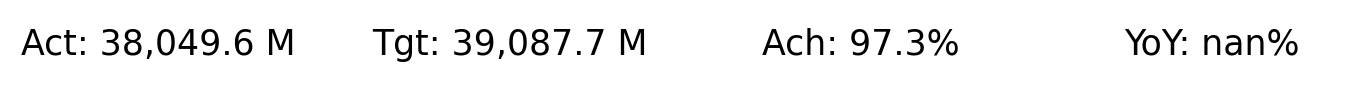

In [16]:
''' Yearly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(ytd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(ytd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

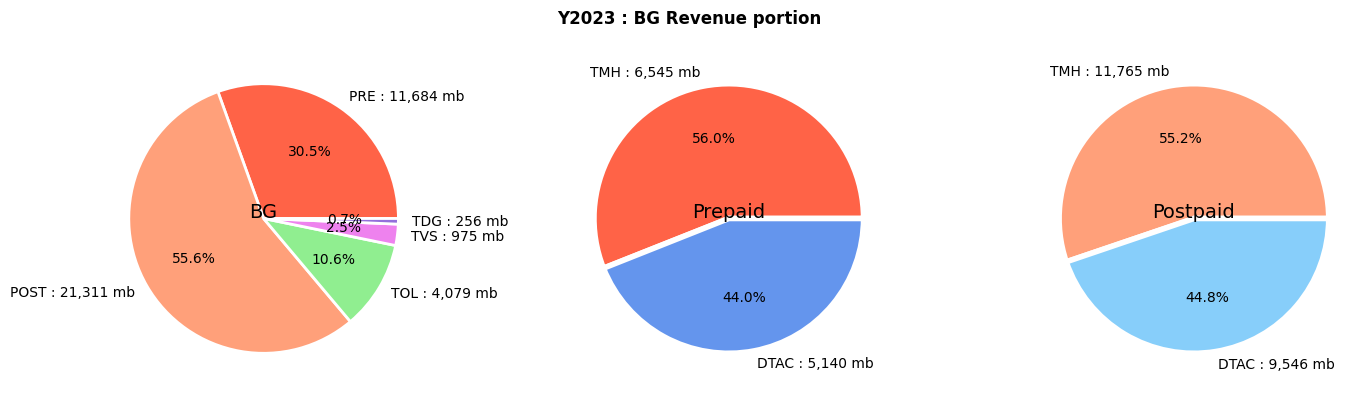

In [17]:
''' Revenue Portion Chart '''

fig = plt.figure(figsize=(14.3, 4))
fig.suptitle(f'Y{curr_yr} : BG Revenue portion', weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([y_yr_act_pre.sum(), y_yr_act_post.sum(), y_yr_act_tol.sum(), y_yr_act_tvs.sum(), y_yr_act_tdg.sum()])
mylabels = [f"PRE : {format(y[0],',.0f')} mb", f"POST : {format(y[1],',.0f')} mb", f"TOL : {format(y[2],',.0f')} mb", f"TVS : {format(y[3],',.0f')} mb", f"TDG : {format(y[4],',.0f')} mb"]
mycolors = ["tomato", "lightsalmon", "lightgreen", "violet",  "mediumpurple"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 2, "edgecolor": "white"})
ax1.text(0, 0, 'BG', ha='center', fontsize=14)

''' ax2 '''
y = np.array([y_yr_act_pre_tmh.sum(), y_yr_act_pre_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["tomato", "cornflowerblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'Prepaid', ha='center', fontsize=14)

''' ax3 '''
y = np.array([y_yr_act_post_tmh.sum(), y_yr_act_post_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} mb", f"DTAC : {format(y[1],',.0f')} mb"]
mycolors = ["lightsalmon", "lightskyblue"]
ax3.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax3.text(0, 0, 'Postpaid', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

## ** Monthly

### MTH : Aggregation

In [18]:
''' Month to Date Values '''

df_last_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==last_mth][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_mth = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_MTH']==curr_mth) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())
# mtd_last_act_tmp = df_last_mth.head(day_cnt_curr_mth)['ACT_BG'].sum()
mtd_last_act = (df_last_mth['ACT_BG'].sum() / len(df_last_mth['TM_KEY_DAY'].unique())) * day_cnt_curr_mth
mtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['ACT_BG'].sum()
mtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['TGT_BG'].sum()
mtd_achv = mtd_act / mtd_tgt
mtd_mom = (mtd_act / mtd_last_act) - 1
mtd_act_gap = mtd_act - mtd_last_act

In [19]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]
df_rev_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_rev_mth['%ACHV'] = df_rev_mth['ACTUAL_SNAP'] / df_rev_mth['TARGET_SNAP']
df_rev_mth['GAP'] = df_rev_mth['ACTUAL_SNAP'] - df_rev_mth['TARGET_SNAP']
df_rev_mth['LAST_ACT'] = df_rev_mth.groupby('METRIC_CD')['ACTUAL_SNAP'].shift()
df_rev_mth['DIFF'] = df_rev_mth['ACTUAL_SNAP'] - df_rev_mth['LAST_ACT']
df_rev_mth['%MOM'] = (df_rev_mth['ACTUAL_SNAP'] / df_rev_mth['LAST_ACT']) - 1

# df_rev_mth.to_excel('df_rev_mth.xlsx')
df_rev_mth.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACTUAL_SNAP,TARGET_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%MOM
31,TB4R000100,TVS Revenue,202306,June,S,53.222028,59.556469,0.893640,-6.334440,376.219863,-322.997835,-0.858535
43126,TNSC00143,TDG Revenue (Conso View),202303,March,N,237.292177,288.000000,0.823931,-50.707823,NaN,NaN,NaN
43154,TNSC00143,TDG Revenue (Conso View),202304,April,N,201.594666,295.000000,0.683372,-93.405334,237.292177,-35.697511,-0.150437
43189,TNSC00143,TDG Revenue (Conso View),202305,May,N,252.000000,278.000000,0.906475,-26.000000,201.594666,50.405334,0.250033
43196,TNSC00143,TDG Revenue (Conso View),202306,June,N,256.000000,254.000000,1.007874,2.000000,252.000000,4.000000,0.015873


In [20]:
''' Pivot by KPIS '''

''' Pivot Actual '''
pv_rev_mth_act = df_rev_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', values='ACTUAL_SNAP').reset_index()
pv_rev_mth_act.rename(columns=({'Postpaid Revenue': 'ACT_POST', 'Postpaid Revenue : DTAC': 'ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'ACT_POST_TMH', 
                                'Prepaid Revenue': 'ACT_PRE', 'Prepaid Revenue : DTAC': 'ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'ACT_PRE_TMH', 
                                'TDG Revenue (Conso View)': 'ACT_TDG', 'TOL Revenue': 'ACT_TOL', 'TVS Revenue': 'ACT_TVS'}), inplace=True)
''' Pivot Target '''
pv_rev_mth_tgt = df_rev_mth.pivot(index='TM_KEY_MTH', columns='METRIC_NAME', values='TARGET_SNAP')
pv_rev_mth_tgt.rename(columns=({'Postpaid Revenue': 'TGT_POST', 'Postpaid Revenue : DTAC': 'TGT_POST_DTAC', 'Postpaid Revenue : TMH': 'TGT_POST_TMH', 
                                'Prepaid Revenue': 'TGT_PRE', 'Prepaid Revenue : DTAC': 'TGT_PRE_DTAC', 'Prepaid Revenue : TMH': 'TGT_PRE_TMH', 
                                'TDG Revenue (Conso View)': 'TGT_TDG', 'TOL Revenue': 'TGT_TOL', 'TVS Revenue': 'TGT_TVS'}), inplace=True)
''' Pivot %Achievement '''
pv_rev_mth_achv = df_rev_mth.pivot(index='TM_KEY_MTH', columns='METRIC_NAME', values='%ACHV')
pv_rev_mth_achv.rename(columns=({'Postpaid Revenue': '%ACHV_POST', 'Postpaid Revenue : DTAC': '%ACHV_POST_DTAC', 'Postpaid Revenue : TMH': '%ACHV_POST_TMH', 
                                 'Prepaid Revenue': '%ACHV_PRE', 'Prepaid Revenue : DTAC': '%ACHV_PRE_DTAC', 'Prepaid Revenue : TMH': '%ACHV_PRE_TMH', 
                                 'TDG Revenue (Conso View)': '%ACHV_TDG', 'TOL Revenue': '%ACHV_TOL', 'TVS Revenue': '%ACHV_TVS'}), inplace=True)
''' Pivot Gap '''
pv_rev_mth_gap = df_rev_mth.pivot(index='TM_KEY_MTH', columns='METRIC_NAME', values='GAP')
pv_rev_mth_gap.rename(columns=({'Postpaid Revenue': 'GAP_POST', 'Postpaid Revenue : DTAC': 'GAP_POST_DTAC', 'Postpaid Revenue : TMH': 'GAP_POST_TMH', 
                                'Prepaid Revenue': 'GAP_PRE', 'Prepaid Revenue : DTAC': 'GAP_PRE_DTAC', 'Prepaid Revenue : TMH': 'GAP_PRE_TMH', 
                                'TDG Revenue (Conso View)': 'GAP_TDG', 'TOL Revenue': 'GAP_TOL', 'TVS Revenue': 'GAP_TVS'}), inplace=True)
''' Pivot Last Actual '''
pv_rev_mth_last_act = df_rev_mth.pivot(index='TM_KEY_MTH', columns='METRIC_NAME', values='LAST_ACT')
pv_rev_mth_last_act.rename(columns=({'Postpaid Revenue': 'LAST_ACT_POST', 'Postpaid Revenue : DTAC': 'LAST_ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'LAST_ACT_POST_TMH', 
                                     'Prepaid Revenue': 'LAST_ACT_PRE', 'Prepaid Revenue : DTAC': 'LAST_ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'LAST_ACT_PRE_TMH', 
                                     'TDG Revenue (Conso View)': 'LAST_ACT_TDG', 'TOL Revenue': 'LAST_ACT_TOL', 'TVS Revenue': 'LAST_ACT_TVS'}), inplace=True)
''' Pivot Diff Last Actual '''
pv_rev_mth_diff = df_rev_mth.pivot(index='TM_KEY_MTH', columns='METRIC_NAME', values='DIFF')
pv_rev_mth_diff.rename(columns=({'Postpaid Revenue': 'DIFF_POST', 'Postpaid Revenue : DTAC': 'DIFF_POST_DTAC', 'Postpaid Revenue : TMH': 'DIFF_POST_TMH', 
                                 'Prepaid Revenue': 'DIFF_PRE', 'Prepaid Revenue : DTAC': 'DIFF_PRE_DTAC', 'Prepaid Revenue : TMH': 'DIFF_PRE_TMH', 
                                 'TDG Revenue (Conso View)': 'DIFF_TDG', 'TOL Revenue': 'DIFF_TOL', 'TVS Revenue': 'DIFF_TVS'}), inplace=True)
''' Pivot % MoM '''
pv_rev_mth_mom = df_rev_mth.pivot(index='TM_KEY_MTH', columns='METRIC_NAME', values='%MOM')
pv_rev_mth_mom.rename(columns=({'Postpaid Revenue': '%MOM_POST', 'Postpaid Revenue : DTAC': '%MOM_POST_DTAC', 'Postpaid Revenue : TMH': '%MOM_POST_TMH', 
                                'Prepaid Revenue': '%MOM_PRE', 'Prepaid Revenue : DTAC': '%MOM_PRE_DTAC', 'Prepaid Revenue : TMH': '%MOM_PRE_TMH', 
                                'TDG Revenue (Conso View)': '%MOM_TDG', 'TOL Revenue': '%MOM_TOL', 'TVS Revenue': '%MOM_TVS'}), inplace=True)

''' Merge all dataframe '''
all_pv_mth = [pv_rev_mth_act, pv_rev_mth_tgt, pv_rev_mth_achv, pv_rev_mth_gap, pv_rev_mth_last_act, pv_rev_mth_diff, pv_rev_mth_mom]
df_rev_mth_agg = reduce(lambda left, right: pd.merge(left, right, on='TM_KEY_MTH'), all_pv_mth)
df_rev_mth_agg.tail(3)

METRIC_NAME,TM_KEY_MTH,MTH_DESC,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,ACT_PRE_DTAC,ACT_PRE_TMH,ACT_TDG,ACT_TOL,...,DIFF_TVS,%MOM_POST,%MOM_POST_DTAC,%MOM_POST_TMH,%MOM_PRE,%MOM_PRE_DTAC,%MOM_PRE_TMH,%MOM_TDG,%MOM_TOL,%MOM_TVS
1,202304,April,6654.114487,2960.554432,3693.560055,3584.677321,1569.575558,2015.101763,201.594666,1405.515708,...,1.566500,0.007720,-0.007820,0.020531,-0.026844,-0.031270,-0.023367,-0.150437,0.002935,0.005756
2,202305,May,6582.950294,2953.069229,3629.881064,3733.741967,1610.280929,2123.461039,252.000000,1272.301320,...,102.524541,-0.010695,-0.002528,-0.017241,0.041584,0.025934,0.053774,0.250033,-0.094780,0.374594
3,202306,June,1470.469156,648.035063,822.434093,682.480243,339.721349,342.758894,256.000000,0.000000,...,-322.997835,-0.776625,-0.780555,-0.773427,-0.817213,-0.789030,-0.838585,0.015873,-1.000000,-0.858535


In [21]:
''' Add column for BG Summary '''

df_rev_mth_agg['ACT_BG'] = df_rev_mth_agg[list(bg_act_col_list)].sum(axis=1)
df_rev_mth_agg['TGT_BG'] = df_rev_mth_agg[list(bg_tgt_col_list)].sum(axis=1)
df_rev_mth_agg['%ACHV_BG'] = df_rev_mth_agg['ACT_BG'] / df_rev_mth_agg['TGT_BG']
df_rev_mth_agg['GAP_BG'] = df_rev_mth_agg['ACT_BG'] - df_rev_mth_agg['TGT_BG']
df_rev_mth_agg['LAST_ACT_BG'] = df_rev_mth_agg[list(bg_last_act_col_list)].sum(axis=1)
df_rev_mth_agg['DIFF_BG'] = np.where(df_rev_mth_agg['LAST_ACT_BG']<=0, 0, df_rev_mth_agg['ACT_BG']-df_rev_mth_agg['LAST_ACT_BG'])
df_rev_mth_agg['%MOM_BG'] = np.where(df_rev_mth_agg['LAST_ACT_BG']<=0, 0, (df_rev_mth_agg['ACT_BG']/df_rev_mth_agg['LAST_ACT_BG'])-1)

df_rev_mth_agg.tail(3)

METRIC_NAME,TM_KEY_MTH,MTH_DESC,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,ACT_PRE_DTAC,ACT_PRE_TMH,ACT_TDG,ACT_TOL,...,%MOM_TDG,%MOM_TOL,%MOM_TVS,ACT_BG,TGT_BG,%ACHV_BG,GAP_BG,LAST_ACT_BG,DIFF_BG,%MOM_BG
1,202304,April,6654.114487,2960.554432,3693.560055,3584.677321,1569.575558,2015.101763,201.594666,1405.515708,...,-0.150437,0.002935,0.005756,11918.002837,12232.510932,0.974289,-314.508095,11960.229993,-42.227156,-0.003531
2,202305,May,6582.950294,2953.069229,3629.881064,3733.741967,1610.280929,2123.461039,252.000000,1272.301320,...,0.250033,-0.094780,0.374594,11965.213444,12243.253305,0.977290,-278.039860,11918.002837,47.210607,0.003961
3,202306,June,1470.469156,648.035063,822.434093,682.480243,339.721349,342.758894,256.000000,0.000000,...,0.015873,-1.000000,-0.858535,2206.171427,2340.366386,0.942661,-134.194959,11965.213444,-9759.042017,-0.815618


In [22]:
''' Month Chart Values '''

x_mth = df_rev_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' Actual '''
y_mth_act = df_rev_mth_agg['ACT_BG']
y_mth_act_post = df_rev_mth_agg['ACT_POST']
y_mth_act_post_dtac = df_rev_mth_agg['ACT_POST_DTAC']
y_mth_act_post_tmh = df_rev_mth_agg['ACT_POST_TMH']
y_mth_act_pre = df_rev_mth_agg['ACT_PRE']
y_mth_act_pre_dtac = df_rev_mth_agg['ACT_PRE_DTAC']
y_mth_act_pre_tmh = df_rev_mth_agg['ACT_PRE_TMH']
y_mth_act_tdg = df_rev_mth_agg['ACT_TDG']
y_mth_act_tol = df_rev_mth_agg['ACT_TOL']
y_mth_act_tvs = df_rev_mth_agg['ACT_TVS']

''' Target '''
y_mth_tgt = df_rev_mth_agg['TGT_BG']
y_mth_tgt_post = df_rev_mth_agg['TGT_POST']
y_mth_tgt_post_dtac = df_rev_mth_agg['TGT_POST_DTAC']
y_mth_tgt_post_tmh = df_rev_mth_agg['TGT_POST_TMH']
y_mth_tgt_pre = df_rev_mth_agg['TGT_PRE']
y_mth_tgt_pre_dtac = df_rev_mth_agg['TGT_PRE_DTAC']
y_mth_tgt_pre_tmh = df_rev_mth_agg['TGT_PRE_TMH']
y_mth_tgt_tdg = df_rev_mth_agg['TGT_TDG']
y_mth_tgt_tol = df_rev_mth_agg['TGT_TOL']
y_mth_tgt_tvs = df_rev_mth_agg['TGT_TVS']

''' % Achievement '''
y_mth_achv = df_rev_mth_agg['%ACHV_BG']
y_mth_achv_post = df_rev_mth_agg['%ACHV_POST']
y_mth_achv_post_dtac = df_rev_mth_agg['%ACHV_POST_DTAC']
y_mth_achv_post_tmh = df_rev_mth_agg['%ACHV_POST_TMH']
y_mth_achv_pre = df_rev_mth_agg['%ACHV_PRE']
y_mth_achv_pre_dtac = df_rev_mth_agg['%ACHV_PRE_DTAC']
y_mth_achv_pre_tmh = df_rev_mth_agg['%ACHV_PRE_TMH']
y_mth_achv_tdg = df_rev_mth_agg['%ACHV_TDG']
y_mth_achv_tol = df_rev_mth_agg['%ACHV_TOL']
y_mth_achv_tvs = df_rev_mth_agg['%ACHV_TVS']

''' Gap '''
y_mth_gap = df_rev_mth_agg['GAP_BG']
y_mth_gap_post = df_rev_mth_agg['GAP_POST']
y_mth_gap_post_dtac = df_rev_mth_agg['GAP_POST_DTAC']
y_mth_gap_post_tmh = df_rev_mth_agg['GAP_POST_TMH']
y_mth_gap_pre = df_rev_mth_agg['GAP_PRE']
y_mth_gap_pre_dtac = df_rev_mth_agg['GAP_PRE_DTAC']
y_mth_gap_pre_tmh = df_rev_mth_agg['GAP_PRE_TMH']
y_mth_gap_tdg = df_rev_mth_agg['GAP_TDG']
y_mth_gap_tol = df_rev_mth_agg['GAP_TOL']
y_mth_gap_tvs = df_rev_mth_agg['GAP_TVS']

''' Last Actual '''
y_mth_last_act = df_rev_mth_agg['LAST_ACT_BG']
y_mth_last_act_post = df_rev_mth_agg['LAST_ACT_POST']
y_mth_last_act_post_dtac = df_rev_mth_agg['LAST_ACT_POST_DTAC']
y_mth_last_act_post_tmh = df_rev_mth_agg['LAST_ACT_POST_TMH']
y_mth_last_act_pre = df_rev_mth_agg['LAST_ACT_PRE']
y_mth_last_act_pre_dtac = df_rev_mth_agg['LAST_ACT_PRE_DTAC']
y_mth_last_act_pre_tmh = df_rev_mth_agg['LAST_ACT_PRE_TMH']
y_mth_last_act_tdg = df_rev_mth_agg['LAST_ACT_TDG']
y_mth_last_act_tol = df_rev_mth_agg['LAST_ACT_TOL']
y_mth_last_act_tvs = df_rev_mth_agg['LAST_ACT_TVS']

''' Diff Last Actual '''
y_mth_diff = df_rev_mth_agg['DIFF_BG']
y_mth_diff_post = df_rev_mth_agg['DIFF_POST']
y_mth_diff_post_dtac = df_rev_mth_agg['DIFF_POST_DTAC']
y_mth_diff_post_tmh = df_rev_mth_agg['DIFF_POST_TMH']
y_mth_diff_pre = df_rev_mth_agg['DIFF_PRE']
y_mth_diff_pre_dtac = df_rev_mth_agg['DIFF_PRE_DTAC']
y_mth_diff_pre_tmh = df_rev_mth_agg['DIFF_PRE_TMH']
y_mth_diff_tdg = df_rev_mth_agg['DIFF_TDG']
y_mth_diff_tol = df_rev_mth_agg['DIFF_TOL']
y_mth_diff_tvs = df_rev_mth_agg['DIFF_TVS']

''' % MoM '''
y_mth_mom = df_rev_mth_agg['%MOM_BG']
y_mth_mom_post = df_rev_mth_agg['%MOM_POST']
y_mth_mom_post_dtac = df_rev_mth_agg['%MOM_POST_DTAC']
y_mth_mom_post_tmh = df_rev_mth_agg['%MOM_POST_TMH']
y_mth_mom_pre = df_rev_mth_agg['%MOM_PRE']
y_mth_mom_pre_dtac = df_rev_mth_agg['%MOM_PRE_DTAC']
y_mth_mom_pre_tmh = df_rev_mth_agg['%MOM_PRE_TMH']
y_mth_mom_tdg = df_rev_mth_agg['%MOM_TDG']
y_mth_mom_tol = df_rev_mth_agg['%MOM_TOL']
y_mth_mom_tvs = df_rev_mth_agg['%MOM_TVS']

### MTH : Business Growth Revenue Summary

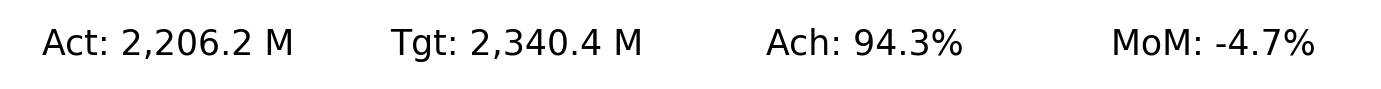

In [23]:
''' Monthly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(mtd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(mtd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

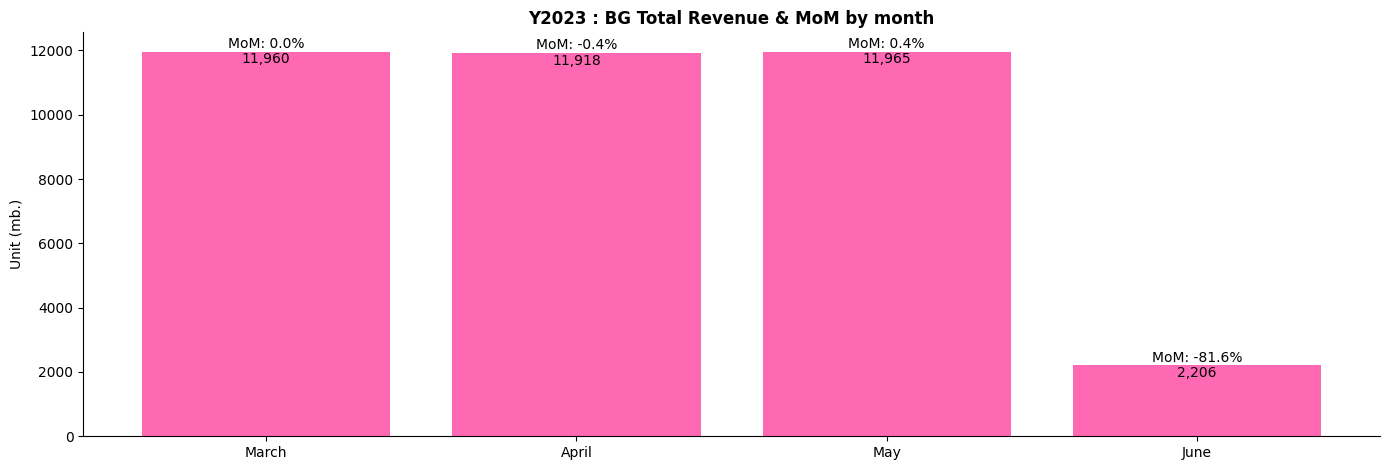

In [24]:
''' Total Revenue & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : BG Total Revenue & MoM by month", weight='bold')
plt.bar(x_mth_axis, y_mth_act, label='Total', color='hotpink')
for i in x_mth_axis:
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act[i]+20), ha='center', va='bottom')
    plt.annotate(format(y_mth_act[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-20), ha='center', va='top')

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
# plt.legend()
plt.tight_layout()
plt.show()

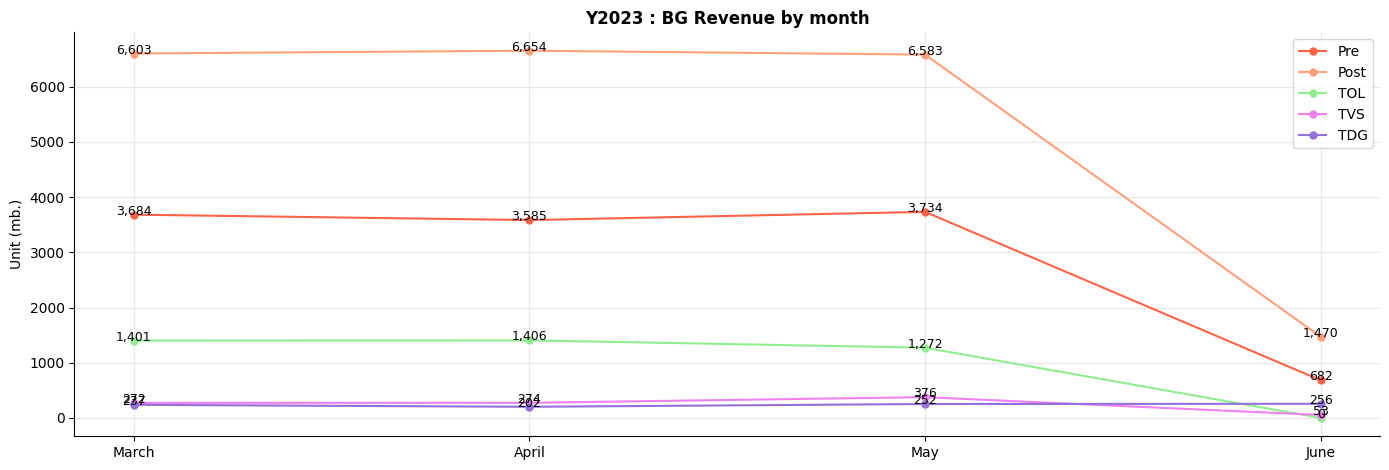

In [25]:
''' Revenue : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : BG Revenue by month", weight='bold')
plt.plot(x_mth_axis, y_mth_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_mth_axis, y_mth_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_mth_axis, y_mth_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_mth_axis, y_mth_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_mth_axis, y_mth_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_mth_axis:
    plt.annotate(format(y_mth_act_pre[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_post[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tol[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tol[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tvs[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tvs[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tdg[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tdg[i]), ha='center', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

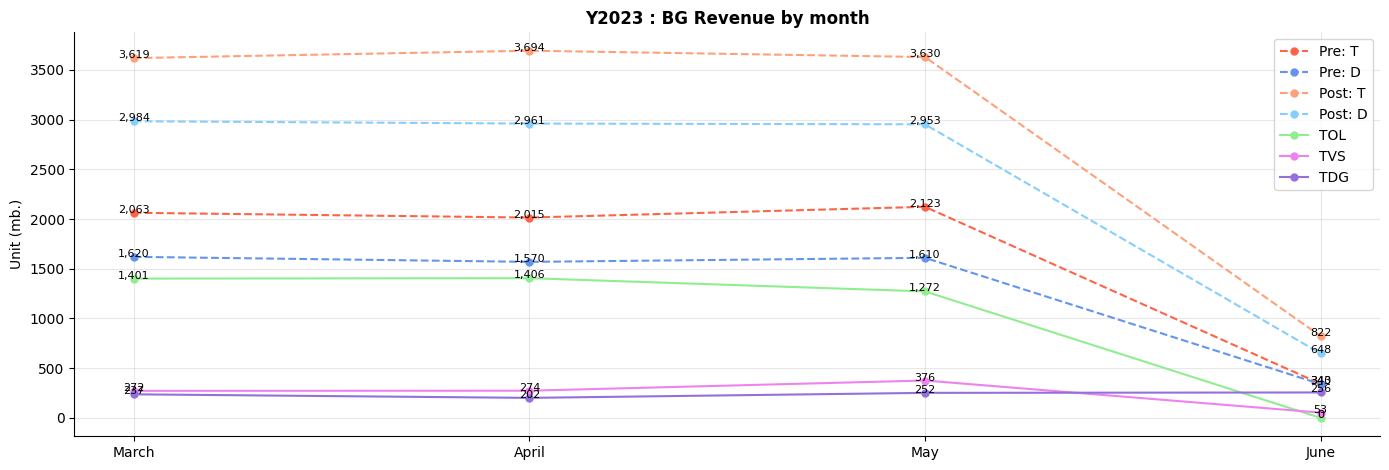

In [26]:
''' Revenue(Mobile separated by TMH, DTAC) : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : BG Revenue by month", weight='bold')
plt.plot(x_mth_axis, y_mth_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_mth_axis, y_mth_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_mth_axis, y_mth_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_mth_axis, y_mth_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_mth_axis, y_mth_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_mth_axis, y_mth_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_mth_axis, y_mth_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_mth_axis:
    plt.annotate(format(y_mth_act_pre_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_pre_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_post_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_post_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tol[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tvs[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tdg[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## ** Weekly

### WK : Aggregation

In [27]:
''' Week to Date Values '''

df_last_wk = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==last_wk][['TM_KEY_DAY', 'TM_KEY_WK', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_wk = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_WK']==curr_wk) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())
# wtd_last_act_tmp = df_last_wk.head(day_cnt_curr_wk)['ACT_BG'].sum()
wtd_last_act = (df_last_wk['ACT_BG'].sum() / len(df_last_wk['TM_KEY_DAY'].unique())) * day_cnt_curr_wk
wtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['ACT_BG'].sum()
wtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['TGT_BG'].sum()
wtd_achv = wtd_act / wtd_tgt
wtd_wow = (wtd_act / wtd_last_act) - 1
wtd_act_gap = wtd_act - wtd_last_act

In [28]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]
df_rev_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

# ''' Aggregation '''
df_rev_wk['%ACHV'] = df_rev_wk['ACTUAL_SNAP'] / df_rev_wk['TARGET_SNAP']
df_rev_wk['GAP'] = df_rev_wk['ACTUAL_SNAP'] - df_rev_wk['TARGET_SNAP']
df_rev_wk['LAST_ACT'] = df_rev_wk.groupby('METRIC_CD')['ACTUAL_SNAP'].shift()
df_rev_wk['DIFF'] = df_rev_wk['ACTUAL_SNAP'] - df_rev_wk['LAST_ACT']
df_rev_wk['%WOW'] = (df_rev_wk['ACTUAL_SNAP'] / df_rev_wk['LAST_ACT']) - 1

# df_rev_wk.to_excel('df_rev_wk.xlsx')
df_rev_wk.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,AGG_TYPE,ACTUAL_SNAP,TARGET_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%WOW
43182,TNSC00143,TDG Revenue (Conso View),2023021,21,N,258.0,278.0,0.928058,-20.0,258.0,0.0,0.000000
43189,TNSC00143,TDG Revenue (Conso View),2023022,22,N,252.0,278.0,0.906475,-26.0,258.0,-6.0,-0.023256
43196,TNSC00143,TDG Revenue (Conso View),2023023,23,N,256.0,254.0,1.007874,2.0,252.0,4.0,0.015873


In [29]:
''' Pivot by KPIS '''

''' Pivot Actual '''
pv_rev_wk_act = df_rev_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', values='ACTUAL_SNAP').reset_index()
pv_rev_wk_act.rename(columns=({'Postpaid Revenue': 'ACT_POST', 'Postpaid Revenue : DTAC': 'ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'ACT_POST_TMH', 
                                'Prepaid Revenue': 'ACT_PRE', 'Prepaid Revenue : DTAC': 'ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'ACT_PRE_TMH', 
                                'TDG Revenue (Conso View)': 'ACT_TDG', 'TOL Revenue': 'ACT_TOL', 'TVS Revenue': 'ACT_TVS'}), inplace=True)
''' Pivot Target '''
pv_rev_wk_tgt = df_rev_wk.pivot(index=['TM_KEY_WK'], columns='METRIC_NAME', values='TARGET_SNAP')
pv_rev_wk_tgt.rename(columns=({'Postpaid Revenue': 'TGT_POST', 'Postpaid Revenue : DTAC': 'TGT_POST_DTAC', 'Postpaid Revenue : TMH': 'TGT_POST_TMH', 
                                'Prepaid Revenue': 'TGT_PRE', 'Prepaid Revenue : DTAC': 'TGT_PRE_DTAC', 'Prepaid Revenue : TMH': 'TGT_PRE_TMH', 
                                'TDG Revenue (Conso View)': 'TGT_TDG', 'TOL Revenue': 'TGT_TOL', 'TVS Revenue': 'TGT_TVS'}), inplace=True)
''' Pivot %Achievement '''
pv_rev_wk_achv = df_rev_wk.pivot(index=['TM_KEY_WK'], columns='METRIC_NAME', values='%ACHV')
pv_rev_wk_achv.rename(columns=({'Postpaid Revenue': '%ACHV_POST', 'Postpaid Revenue : DTAC': '%ACHV_POST_DTAC', 'Postpaid Revenue : TMH': '%ACHV_POST_TMH', 
                                 'Prepaid Revenue': '%ACHV_PRE', 'Prepaid Revenue : DTAC': '%ACHV_PRE_DTAC', 'Prepaid Revenue : TMH': '%ACHV_PRE_TMH', 
                                 'TDG Revenue (Conso View)': '%ACHV_TDG', 'TOL Revenue': '%ACHV_TOL', 'TVS Revenue': '%ACHV_TVS'}), inplace=True)
''' Pivot Gap '''
pv_rev_wk_gap = df_rev_wk.pivot(index=['TM_KEY_WK'], columns='METRIC_NAME', values='GAP')
pv_rev_wk_gap.rename(columns=({'Postpaid Revenue': 'GAP_POST', 'Postpaid Revenue : DTAC': 'GAP_POST_DTAC', 'Postpaid Revenue : TMH': 'GAP_POST_TMH', 
                                'Prepaid Revenue': 'GAP_PRE', 'Prepaid Revenue : DTAC': 'GAP_PRE_DTAC', 'Prepaid Revenue : TMH': 'GAP_PRE_TMH', 
                                'TDG Revenue (Conso View)': 'GAP_TDG', 'TOL Revenue': 'GAP_TOL', 'TVS Revenue': 'GAP_TVS'}), inplace=True)
''' Pivot Last Actual '''
pv_rev_wk_last_act = df_rev_wk.pivot(index=['TM_KEY_WK'], columns='METRIC_NAME', values='LAST_ACT')
pv_rev_wk_last_act.rename(columns=({'Postpaid Revenue': 'LAST_ACT_POST', 'Postpaid Revenue : DTAC': 'LAST_ACT_POST_DTAC', 'Postpaid Revenue : TMH': 'LAST_ACT_POST_TMH', 
                                     'Prepaid Revenue': 'LAST_ACT_PRE', 'Prepaid Revenue : DTAC': 'LAST_ACT_PRE_DTAC', 'Prepaid Revenue : TMH': 'LAST_ACT_PRE_TMH', 
                                     'TDG Revenue (Conso View)': 'LAST_ACT_TDG', 'TOL Revenue': 'LAST_ACT_TOL', 'TVS Revenue': 'LAST_ACT_TVS'}), inplace=True)
''' Pivot Diff Last Actual '''
pv_rev_wk_diff = df_rev_wk.pivot(index=['TM_KEY_WK'], columns='METRIC_NAME', values='DIFF')
pv_rev_wk_diff.rename(columns=({'Postpaid Revenue': 'DIFF_POST', 'Postpaid Revenue : DTAC': 'DIFF_POST_DTAC', 'Postpaid Revenue : TMH': 'DIFF_POST_TMH', 
                                 'Prepaid Revenue': 'DIFF_PRE', 'Prepaid Revenue : DTAC': 'DIFF_PRE_DTAC', 'Prepaid Revenue : TMH': 'DIFF_PRE_TMH', 
                                 'TDG Revenue (Conso View)': 'DIFF_TDG', 'TOL Revenue': 'DIFF_TOL', 'TVS Revenue': 'DIFF_TVS'}), inplace=True)
''' Pivot % WoW '''
pv_rev_wk_wow = df_rev_wk.pivot(index=['TM_KEY_WK'], columns='METRIC_NAME', values='%WOW')
pv_rev_wk_wow.rename(columns=({'Postpaid Revenue': '%WOW_POST', 'Postpaid Revenue : DTAC': '%WOW_POST_DTAC', 'Postpaid Revenue : TMH': '%WOW_POST_TMH', 
                                'Prepaid Revenue': '%WOW_PRE', 'Prepaid Revenue : DTAC': '%WOW_PRE_DTAC', 'Prepaid Revenue : TMH': '%WOW_PRE_TMH', 
                                'TDG Revenue (Conso View)': '%WOW_TDG', 'TOL Revenue': '%WOW_TOL', 'TVS Revenue': '%WOW_TVS'}), inplace=True)

''' Merge all dataframe '''
all_pv_wk = [pv_rev_wk_act, pv_rev_wk_tgt, pv_rev_wk_achv, pv_rev_wk_gap, pv_rev_wk_last_act, pv_rev_wk_diff, pv_rev_wk_wow]
df_rev_wk_agg = reduce(lambda left, right: pd.merge(left, right, on='TM_KEY_WK'), all_pv_wk)
df_rev_wk_agg.tail(3)

METRIC_NAME,TM_KEY_WK,WK_LABEL,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,ACT_PRE_DTAC,ACT_PRE_TMH,ACT_TDG,ACT_TOL,...,DIFF_TVS,%WOW_POST,%WOW_POST_DTAC,%WOW_POST_TMH,%WOW_PRE,%WOW_PRE_DTAC,%WOW_PRE_TMH,%WOW_TDG,%WOW_TOL,%WOW_TVS
12,2023021,21,1749.401712,639.606530,1109.795181,817.699159,350.000495,467.698664,258.0,300.254581,...,26.359556,0.281275,0.033302,0.486929,0.009918,0.001050,0.016658,0.000000,-0.021376,0.496167
13,2023022,22,1364.359474,764.967575,599.391899,942.800527,402.414983,540.385544,252.0,0.000000,...,88.631325,-0.220099,0.195997,-0.459908,0.152992,0.149755,0.155414,-0.023256,-1.000000,1.115057
14,2023023,23,425.283949,194.597887,230.686062,149.248468,107.663192,41.585277,256.0,0.000000,...,-156.321268,-0.688290,-0.745613,-0.615133,-0.841697,-0.732457,-0.923045,0.015873,NaN,-0.929835


In [30]:
''' Add column for BG Summary '''

df_rev_wk_agg['ACT_BG'] = df_rev_wk_agg[list(bg_act_col_list)].sum(axis=1)
df_rev_wk_agg['TGT_BG'] = df_rev_wk_agg[list(bg_tgt_col_list)].sum(axis=1)
df_rev_wk_agg['%ACHV_BG'] = df_rev_wk_agg['ACT_BG'] / df_rev_wk_agg['TGT_BG']
df_rev_wk_agg['GAP_BG'] = df_rev_wk_agg['ACT_BG'] - df_rev_wk_agg['TGT_BG']
df_rev_wk_agg['LAST_ACT_BG'] = df_rev_wk_agg[list(bg_last_act_col_list)].sum(axis=1)
df_rev_wk_agg['DIFF_BG'] = np.where(df_rev_wk_agg['LAST_ACT_BG']<=0, 0, df_rev_wk_agg['ACT_BG']-df_rev_wk_agg['LAST_ACT_BG'])
df_rev_wk_agg['%WOW_BG'] = np.where(df_rev_wk_agg['LAST_ACT_BG']<=0, 0, (df_rev_wk_agg['ACT_BG']/df_rev_wk_agg['LAST_ACT_BG'])-1)

df_rev_wk_agg.tail(3)

METRIC_NAME,TM_KEY_WK,WK_LABEL,ACT_POST,ACT_POST_DTAC,ACT_POST_TMH,ACT_PRE,ACT_PRE_DTAC,ACT_PRE_TMH,ACT_TDG,ACT_TOL,...,%WOW_TDG,%WOW_TOL,%WOW_TVS,ACT_BG,TGT_BG,%ACHV_BG,GAP_BG,LAST_ACT_BG,DIFF_BG,%WOW_BG
12,2023021,21,1749.401712,639.606530,1109.795181,817.699159,350.000495,467.698664,258.0,300.254581,...,0.000000,-0.021376,0.496167,2946.841389,3146.262551,0.936616,-199.421161,2534.968051,411.873338,0.162477
13,2023022,22,1364.359474,764.967575,599.391899,942.800527,402.414983,540.385544,252.0,0.000000,...,-0.023256,-1.000000,1.115057,2475.277262,2489.794155,0.994169,-14.516893,2946.841389,-471.564127,-0.160024
14,2023023,23,425.283949,194.597887,230.686062,149.248468,107.663192,41.585277,256.0,0.000000,...,0.015873,NaN,-0.929835,586.328411,694.658784,0.844052,-108.330374,2475.277262,-1888.948852,-0.763126


In [31]:
''' Week Chart Values '''

x_wk = df_rev_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' Actual '''
y_wk_act = df_rev_wk_agg['ACT_BG']
y_wk_act_post = df_rev_wk_agg['ACT_POST']
y_wk_act_post_dtac = df_rev_wk_agg['ACT_POST_DTAC']
y_wk_act_post_tmh = df_rev_wk_agg['ACT_POST_TMH']
y_wk_act_pre = df_rev_wk_agg['ACT_PRE']
y_wk_act_pre_dtac = df_rev_wk_agg['ACT_PRE_DTAC']
y_wk_act_pre_tmh = df_rev_wk_agg['ACT_PRE_TMH']
y_wk_act_tdg = df_rev_wk_agg['ACT_TDG']
y_wk_act_tol = df_rev_wk_agg['ACT_TOL']
y_wk_act_tvs = df_rev_wk_agg['ACT_TVS']

''' Target '''
y_wk_tgt = df_rev_wk_agg['TGT_BG']
y_wk_tgt_post = df_rev_wk_agg['TGT_POST']
y_wk_tgt_post_dtac = df_rev_wk_agg['TGT_POST_DTAC']
y_wk_tgt_post_tmh = df_rev_wk_agg['TGT_POST_TMH']
y_wk_tgt_pre = df_rev_wk_agg['TGT_PRE']
y_wk_tgt_pre_dtac = df_rev_wk_agg['TGT_PRE_DTAC']
y_wk_tgt_pre_tmh = df_rev_wk_agg['TGT_PRE_TMH']
y_wk_tgt_tdg = df_rev_wk_agg['TGT_TDG']
y_wk_tgt_tol = df_rev_wk_agg['TGT_TOL']
y_wk_tgt_tvs = df_rev_wk_agg['TGT_TVS']

''' % Achievement '''
y_wk_achv = df_rev_wk_agg['%ACHV_BG']
y_wk_achv_post = df_rev_wk_agg['%ACHV_POST']
y_wk_achv_post_dtac = df_rev_wk_agg['%ACHV_POST_DTAC']
y_wk_achv_post_tmh = df_rev_wk_agg['%ACHV_POST_TMH']
y_wk_achv_pre = df_rev_wk_agg['%ACHV_PRE']
y_wk_achv_pre_dtac = df_rev_wk_agg['%ACHV_PRE_DTAC']
y_wk_achv_pre_tmh = df_rev_wk_agg['%ACHV_PRE_TMH']
y_wk_achv_tdg = df_rev_wk_agg['%ACHV_TDG']
y_wk_achv_tol = df_rev_wk_agg['%ACHV_TOL']
y_wk_achv_tvs = df_rev_wk_agg['%ACHV_TVS']

''' Gap '''
y_wk_gap = df_rev_wk_agg['GAP_BG']
y_wk_gap_post = df_rev_wk_agg['GAP_POST']
y_wk_gap_post_dtac = df_rev_wk_agg['GAP_POST_DTAC']
y_wk_gap_post_tmh = df_rev_wk_agg['GAP_POST_TMH']
y_wk_gap_pre = df_rev_wk_agg['GAP_PRE']
y_wk_gap_pre_dtac = df_rev_wk_agg['GAP_PRE_DTAC']
y_wk_gap_pre_tmh = df_rev_wk_agg['GAP_PRE_TMH']
y_wk_gap_tdg = df_rev_wk_agg['GAP_TDG']
y_wk_gap_tol = df_rev_wk_agg['GAP_TOL']
y_wk_gap_tvs = df_rev_wk_agg['GAP_TVS']

''' Last Actual '''
y_wk_last_act = df_rev_wk_agg['LAST_ACT_BG']
y_wk_last_act_post = df_rev_wk_agg['LAST_ACT_POST']
y_wk_last_act_post_dtac = df_rev_wk_agg['LAST_ACT_POST_DTAC']
y_wk_last_act_post_tmh = df_rev_wk_agg['LAST_ACT_POST_TMH']
y_wk_last_act_pre = df_rev_wk_agg['LAST_ACT_PRE']
y_wk_last_act_pre_dtac = df_rev_wk_agg['LAST_ACT_PRE_DTAC']
y_wk_last_act_pre_tmh = df_rev_wk_agg['LAST_ACT_PRE_TMH']
y_wk_last_act_tdg = df_rev_wk_agg['LAST_ACT_TDG']
y_wk_last_act_tol = df_rev_wk_agg['LAST_ACT_TOL']
y_wk_last_act_tvs = df_rev_wk_agg['LAST_ACT_TVS']

''' Diff Last Actual '''
y_wk_diff = df_rev_wk_agg['DIFF_BG']
y_wk_diff_post = df_rev_wk_agg['DIFF_POST']
y_wk_diff_post_dtac = df_rev_wk_agg['DIFF_POST_DTAC']
y_wk_diff_post_tmh = df_rev_wk_agg['DIFF_POST_TMH']
y_wk_diff_pre = df_rev_wk_agg['DIFF_PRE']
y_wk_diff_pre_dtac = df_rev_wk_agg['DIFF_PRE_DTAC']
y_wk_diff_pre_tmh = df_rev_wk_agg['DIFF_PRE_TMH']
y_wk_diff_tdg = df_rev_wk_agg['DIFF_TDG']
y_wk_diff_tol = df_rev_wk_agg['DIFF_TOL']
y_wk_diff_tvs = df_rev_wk_agg['DIFF_TVS']

''' % WoW '''
y_wk_wow = df_rev_wk_agg['%WOW_BG']
y_wk_wow_post = df_rev_wk_agg['%WOW_POST']
y_wk_wow_post_dtac = df_rev_wk_agg['%WOW_POST_DTAC']
y_wk_wow_post_tmh = df_rev_wk_agg['%WOW_POST_TMH']
y_wk_wow_pre = df_rev_wk_agg['%WOW_PRE']
y_wk_wow_pre_dtac = df_rev_wk_agg['%WOW_PRE_DTAC']
y_wk_wow_pre_tmh = df_rev_wk_agg['%WOW_PRE_TMH']
y_wk_wow_tdg = df_rev_wk_agg['%WOW_TDG']
y_wk_wow_tol = df_rev_wk_agg['%WOW_TOL']
y_wk_wow_tvs = df_rev_wk_agg['%WOW_TVS']

### WK : Business Growth Revenue Summary

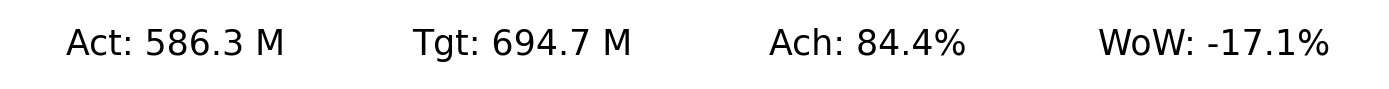

In [32]:
''' Weekly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(wtd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(wtd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

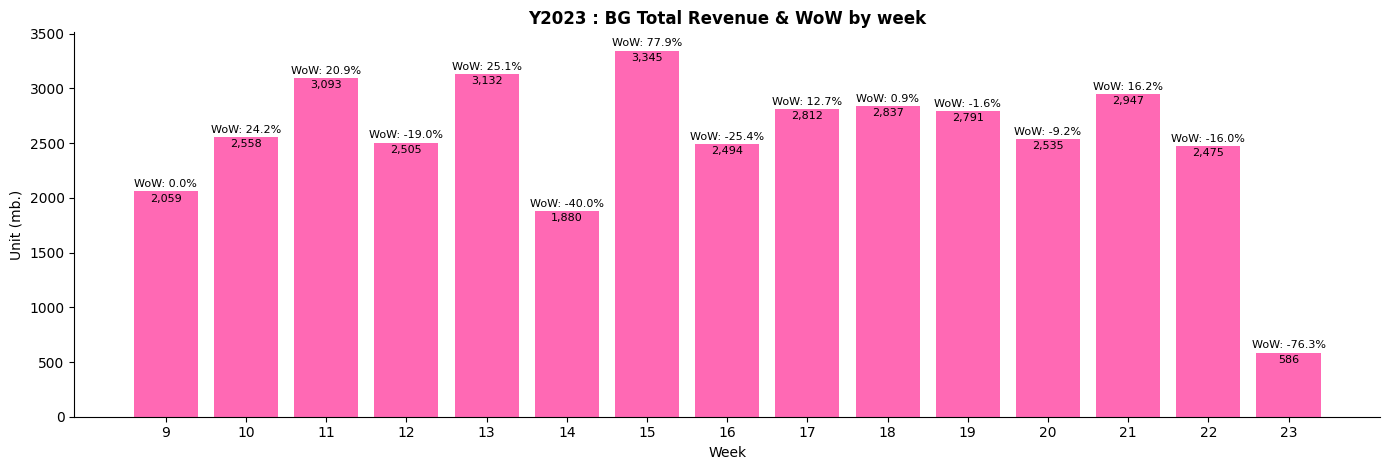

In [33]:
''' Total Revenue & WoW : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : BG Total Revenue & WoW by week", weight='bold')
plt.bar(x_wk_axis, y_wk_act, label='Total', color='hotpink')
for i in x_wk_axis:
    plt.annotate(f"WoW: {format(y_wk_wow[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act[i]+20), ha='center', va='bottom', fontsize=8)
    plt.annotate(format(y_wk_act[i],',.0f'), xy=(x_wk_axis[i], y_wk_act[i]-20), ha='center', va='top', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.tight_layout()
plt.show()

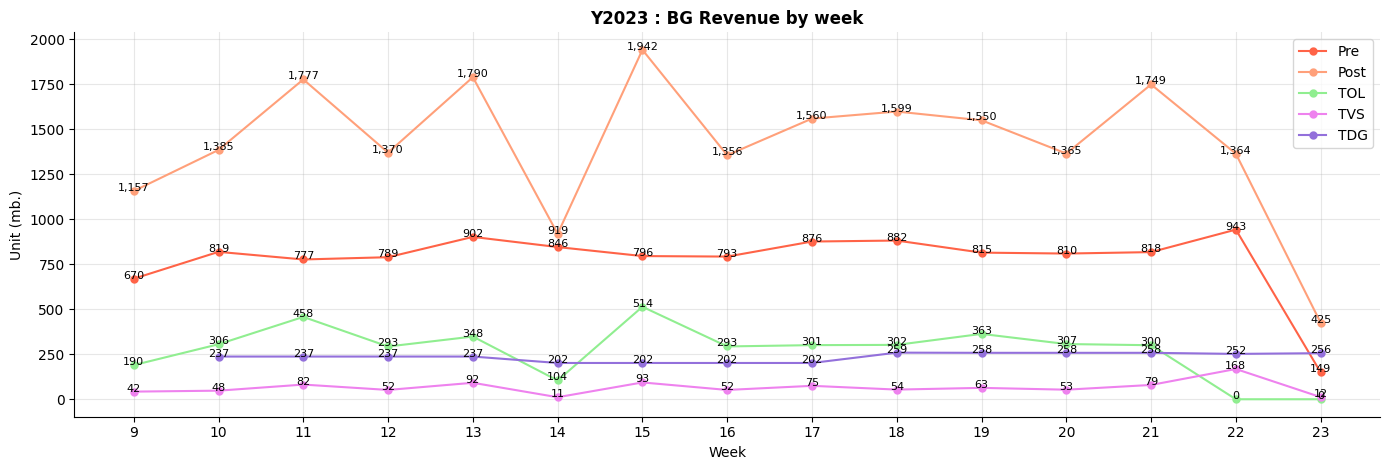

In [34]:
''' Revenue : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : BG Revenue by week", weight='bold')
plt.plot(x_wk_axis, y_wk_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_wk_axis, y_wk_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_wk_axis, y_wk_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_wk_axis, y_wk_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_wk_axis, y_wk_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act_pre[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tol[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tvs[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tdg[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

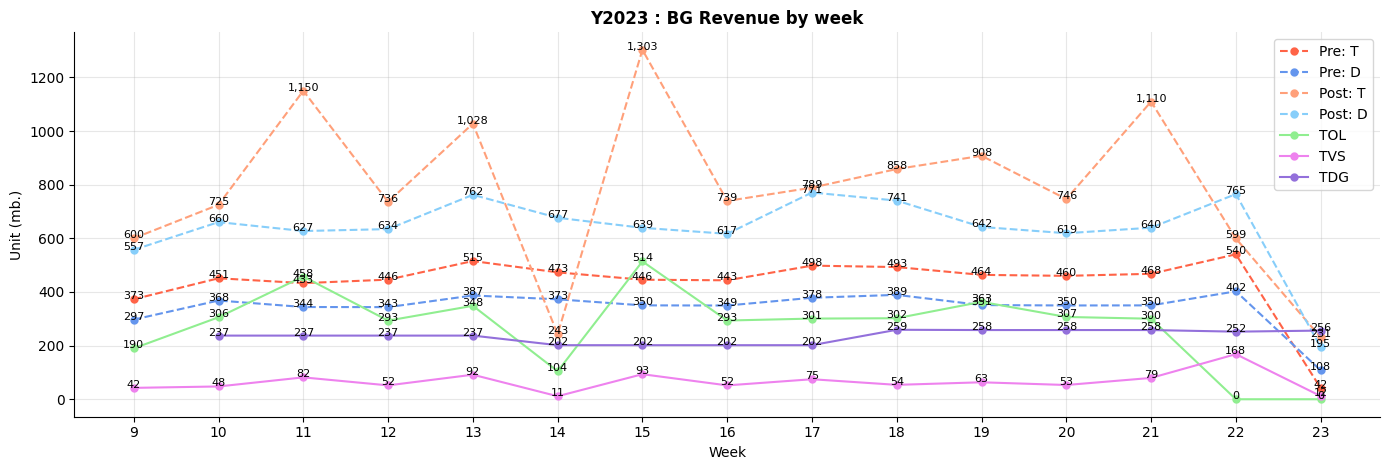

In [35]:
''' Revenue(Mobile separated by TMH, DTAC) : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : BG Revenue by week", weight='bold')
plt.plot(x_wk_axis, y_wk_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_wk_axis, y_wk_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_wk_axis, y_wk_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_wk_axis, y_wk_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_wk_axis, y_wk_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_wk_axis, y_wk_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_wk_axis, y_wk_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act_pre_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_pre_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tol[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tvs[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tdg[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## ** Daily (MTD)

### DAY : Aggregation

In [36]:
''' Create Dataframe '''

# day_end_of_last_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==last_mth]['TM_KEY_DAY'].max()
df_rev_day_curr_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth].reset_index()
df_rev_day_curr_mth.tail()

METRIC_NAME,index,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,ACT_POST,ACT_POST_DTAC,...,%DOD_TDG,%DOD_TOL,%DOD_TVS,ACT_BG,TGT_BG,%ACHV_BG,GAP_BG,LAST_ACT_BG,DIFF_BG,%DOD_BG
1,93,20230602,2023022,202306,20232,2023,June,2,840.767543,249.019512,...,NaN,NaN,NaN,1020.912264,1062.068065,0.961249,-41.155801,155.304189,865.608075,5.573630
2,94,20230603,2023022,202306,20232,2023,June,3,97.676929,97.676929,...,NaN,NaN,NaN,226.945998,224.058971,1.012885,2.887026,1020.912264,-793.966266,-0.777703
3,95,20230604,2023022,202306,20232,2023,June,4,97.417088,97.417088,...,NaN,NaN,NaN,216.680566,222.458777,0.974026,-5.778211,226.945998,-10.265432,-0.045233
4,96,20230605,2023023,202306,20232,2023,June,5,94.137850,94.137850,...,NaN,NaN,NaN,168.234352,221.072901,0.760990,-52.838549,216.680566,-48.446213,-0.223584
5,97,20230606,2023023,202306,20232,2023,June,6,331.146099,100.460037,...,0.0,NaN,NaN,418.094058,473.585883,0.882826,-55.491825,168.234352,249.859706,1.485188


In [37]:
''' Day Chart Values '''

x_day = df_rev_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' Actual '''
y_day_act = df_rev_day_curr_mth['ACT_BG']
y_day_act_post = df_rev_day_curr_mth['ACT_POST']
y_day_act_post_dtac = df_rev_day_curr_mth['ACT_POST_DTAC']
y_day_act_post_tmh = df_rev_day_curr_mth['ACT_POST_TMH']
y_day_act_pre = df_rev_day_curr_mth['ACT_PRE']
y_day_act_pre_dtac = df_rev_day_curr_mth['ACT_PRE_DTAC']
y_day_act_pre_tmh = df_rev_day_curr_mth['ACT_PRE_TMH']
y_day_act_tdg = df_rev_day_curr_mth['ACT_TDG']
y_day_act_tol = df_rev_day_curr_mth['ACT_TOL']
y_day_act_tvs = df_rev_day_curr_mth['ACT_TVS']

''' Target '''
y_day_tgt = df_rev_day_curr_mth['TGT_BG']
y_day_tgt_post = df_rev_day_curr_mth['TGT_POST']
y_day_tgt_post_dtac = df_rev_day_curr_mth['TGT_POST_DTAC']
y_day_tgt_post_tmh = df_rev_day_curr_mth['TGT_POST_TMH']
y_day_tgt_pre = df_rev_day_curr_mth['TGT_PRE']
y_day_tgt_pre_dtac = df_rev_day_curr_mth['TGT_PRE_DTAC']
y_day_tgt_pre_tmh = df_rev_day_curr_mth['TGT_PRE_TMH']
y_day_tgt_tdg = df_rev_day_curr_mth['TGT_TDG']
y_day_tgt_tol = df_rev_day_curr_mth['TGT_TOL']
y_day_tgt_tvs = df_rev_day_curr_mth['TGT_TVS']

''' % Achievement '''
y_day_achv = df_rev_day_curr_mth['%ACHV_BG']
y_day_achv_post = df_rev_day_curr_mth['%ACHV_POST']
y_day_achv_post_dtac = df_rev_day_curr_mth['%ACHV_POST_DTAC']
y_day_achv_post_tmh = df_rev_day_curr_mth['%ACHV_POST_TMH']
y_day_achv_pre = df_rev_day_curr_mth['%ACHV_PRE']
y_day_achv_pre_dtac = df_rev_day_curr_mth['%ACHV_PRE_DTAC']
y_day_achv_pre_tmh = df_rev_day_curr_mth['%ACHV_PRE_TMH']
y_day_achv_tdg = df_rev_day_curr_mth['%ACHV_TDG']
y_day_achv_tol = df_rev_day_curr_mth['%ACHV_TOL']
y_day_achv_tvs = df_rev_day_curr_mth['%ACHV_TVS']

''' Gap '''
y_day_gap = df_rev_day_curr_mth['GAP_BG']
y_day_gap_post = df_rev_day_curr_mth['GAP_POST']
y_day_gap_post_dtac = df_rev_day_curr_mth['GAP_POST_DTAC']
y_day_gap_post_tmh = df_rev_day_curr_mth['GAP_POST_TMH']
y_day_gap_pre = df_rev_day_curr_mth['GAP_PRE']
y_day_gap_pre_dtac = df_rev_day_curr_mth['GAP_PRE_DTAC']
y_day_gap_pre_tmh = df_rev_day_curr_mth['GAP_PRE_TMH']
y_day_gap_tdg = df_rev_day_curr_mth['GAP_TDG']
y_day_gap_tol = df_rev_day_curr_mth['GAP_TOL']
y_day_gap_tvs = df_rev_day_curr_mth['GAP_TVS']

''' Last Actual '''
y_day_last_act = df_rev_day_curr_mth['LAST_ACT_BG']
y_day_last_act_post = df_rev_day_curr_mth['LAST_ACT_POST']
y_day_last_act_post_dtac = df_rev_day_curr_mth['LAST_ACT_POST_DTAC']
y_day_last_act_post_tmh = df_rev_day_curr_mth['LAST_ACT_POST_TMH']
y_day_last_act_pre = df_rev_day_curr_mth['LAST_ACT_PRE']
y_day_last_act_pre_dtac = df_rev_day_curr_mth['LAST_ACT_PRE_DTAC']
y_day_last_act_pre_tmh = df_rev_day_curr_mth['LAST_ACT_PRE_TMH']
y_day_last_act_tdg = df_rev_day_curr_mth['LAST_ACT_TDG']
y_day_last_act_tol = df_rev_day_curr_mth['LAST_ACT_TOL']
y_day_last_act_tvs = df_rev_day_curr_mth['LAST_ACT_TVS']

''' Diff Last Actual '''
y_day_diff = df_rev_day_curr_mth['DIFF_BG']
y_day_diff_post = df_rev_day_curr_mth['DIFF_POST']
y_day_diff_post_dtac = df_rev_day_curr_mth['DIFF_POST_DTAC']
y_day_diff_post_tmh = df_rev_day_curr_mth['DIFF_POST_TMH']
y_day_diff_pre = df_rev_day_curr_mth['DIFF_PRE']
y_day_diff_pre_dtac = df_rev_day_curr_mth['DIFF_PRE_DTAC']
y_day_diff_pre_tmh = df_rev_day_curr_mth['DIFF_PRE_TMH']
y_day_diff_tdg = df_rev_day_curr_mth['DIFF_TDG']
y_day_diff_tol = df_rev_day_curr_mth['DIFF_TOL']
y_day_diff_tvs = df_rev_day_curr_mth['DIFF_TVS']

''' % DoD '''
y_day_dod = df_rev_day_curr_mth['%DOD_BG']
y_day_dod_post = df_rev_day_curr_mth['%DOD_POST']
y_day_dod_post_dtac = df_rev_day_curr_mth['%DOD_POST_DTAC']
y_day_dod_post_tmh = df_rev_day_curr_mth['%DOD_POST_TMH']
y_day_dod_pre = df_rev_day_curr_mth['%DOD_PRE']
y_day_dod_pre_dtac = df_rev_day_curr_mth['%DOD_PRE_DTAC']
y_day_dod_pre_tmh = df_rev_day_curr_mth['%DOD_PRE_TMH']
y_day_dod_tdg = df_rev_day_curr_mth['%DOD_TDG']
y_day_dod_tol = df_rev_day_curr_mth['%DOD_TOL']
y_day_dod_tvs = df_rev_day_curr_mth['%DOD_TVS']

### DAY : Business Growth Revenue Summary

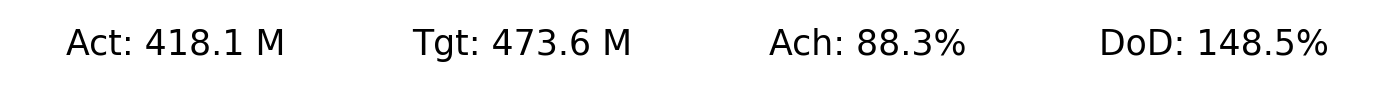

In [38]:
''' Daily Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(y_day_act.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(y_day_tgt.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(y_day_achv.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(y_day_dod.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

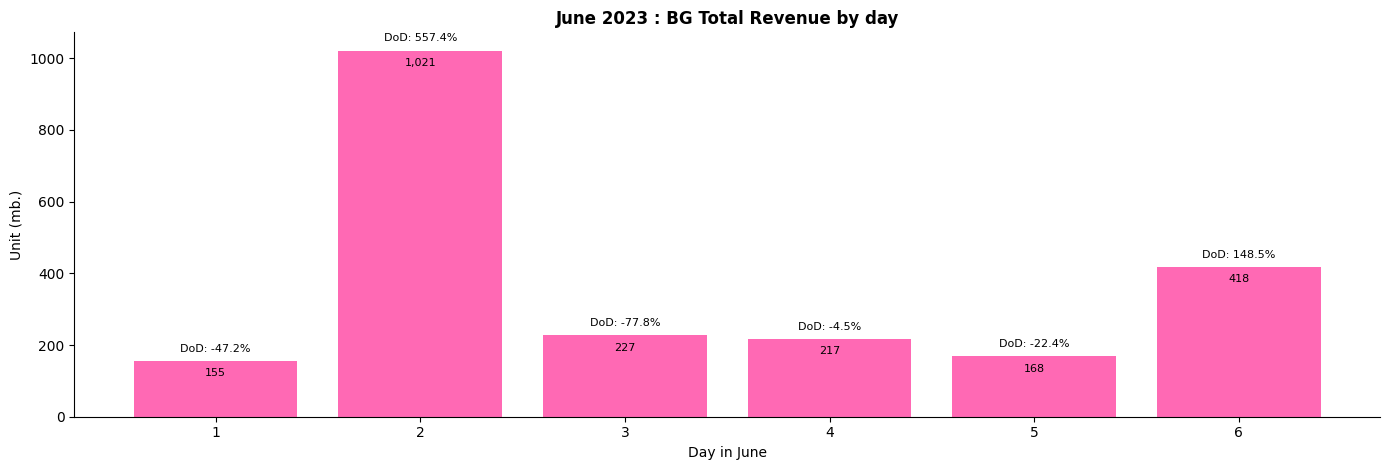

In [39]:
''' Total Revenue & DoD : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : BG Total Revenue by day", fontdict={'fontweight': 'bold'})
plt.bar(x_day_axis, y_day_act, label='Total', color='hotpink')
for i in x_day_axis:
    plt.annotate(f"DoD: {format(y_day_dod[i],',.1%')}", xy=(x_day_axis[i], y_day_act[i]+20), ha='center', va='bottom', fontsize=8)
    plt.annotate(format(y_day_act[i],',.0f'), xy=(x_day_axis[i], y_day_act[i]-20), ha='center', va='top', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day in {curr_mth_desc}')
plt.xticks(x_day_axis, x_day)
plt.tight_layout()
plt.show()

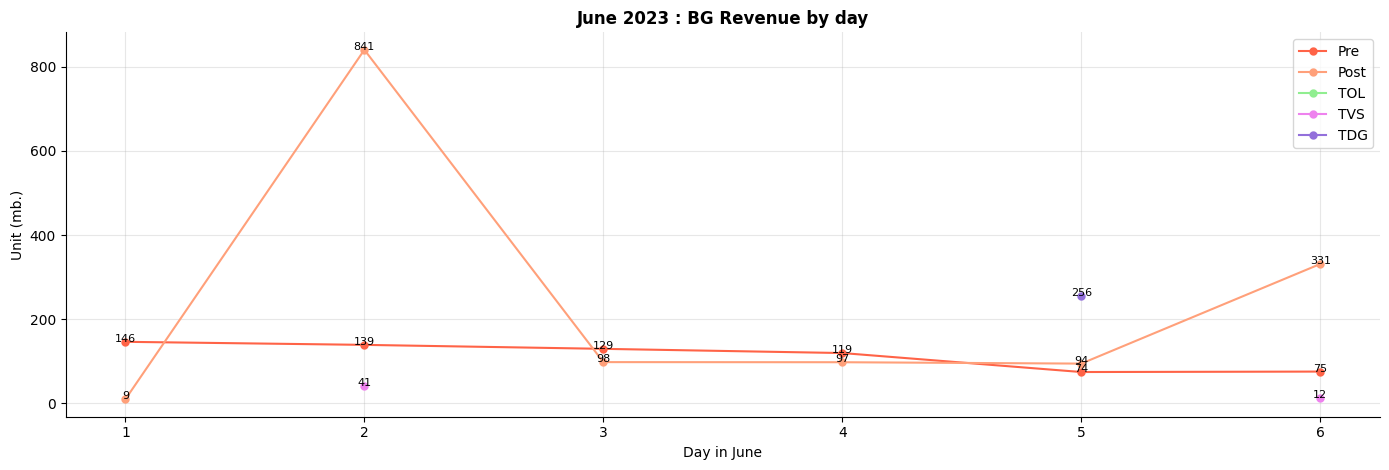

In [40]:
''' Revenue : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : BG Revenue by day", fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_day_axis, y_day_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_day_axis, y_day_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_day_axis, y_day_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_day_axis, y_day_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_day_axis:
    plt.annotate(format(y_day_act_pre[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post[i],',.0f'), xy=(x_day_axis[i], y_day_act_post[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tol[i],',.0f'), xy=(x_day_axis[i], y_day_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tvs[i],',.0f'), xy=(x_day_axis[i], y_day_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tdg[i],',.0f'), xy=(x_day_axis[i], y_day_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day in {curr_mth_desc}')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

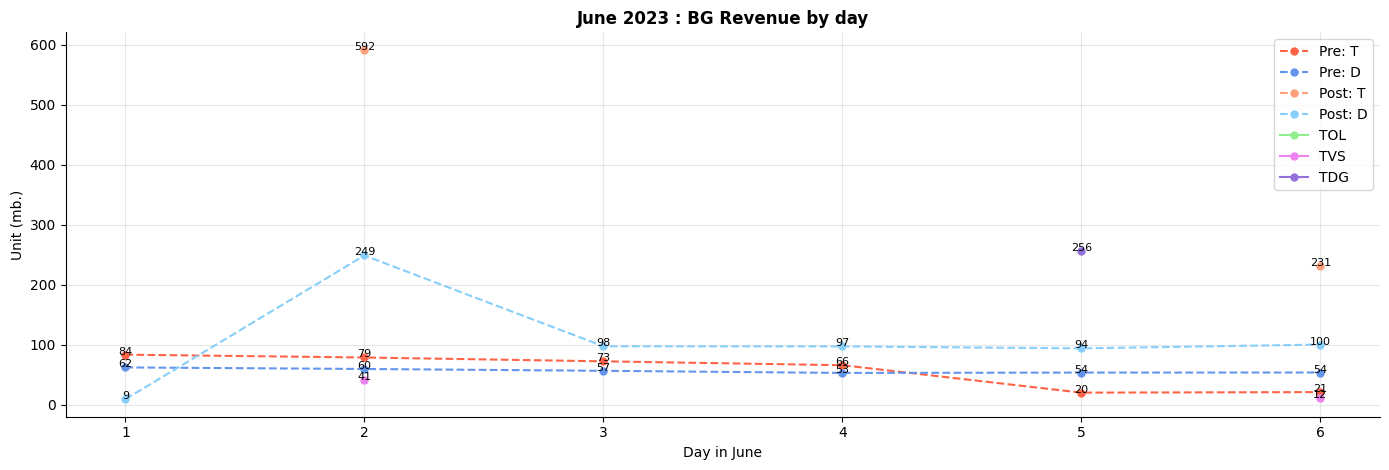

In [41]:
''' Revenue(Mobile separated by TMH, DTAC) : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : BG Revenue by day", fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_day_axis, y_day_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_day_axis, y_day_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_day_axis, y_day_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_day_axis, y_day_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_day_axis, y_day_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
plt.plot(x_day_axis, y_day_act_tdg, marker='.', markeredgewidth=3, label='TDG', color='mediumpurple')
for i in x_day_axis:
    plt.annotate(format(y_day_act_pre_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_pre_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tol[i],',.0f'), xy=(x_day_axis[i], y_day_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tvs[i],',.0f'), xy=(x_day_axis[i], y_day_act_tvs[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tdg[i],',.0f'), xy=(x_day_axis[i], y_day_act_tdg[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day in {curr_mth_desc}')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()